In [1]:
import os
import importlib.util
from IPython.display import display
import sympy as sym
from sympy.assumptions.assume import global_assumptions
import pandas as pd
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.optimize import root
from scipy.signal import argrelextrema
seed = 73
CARTESIAN = 0
CYLINDRICAL = 1
SPHERICAL = 2
np.random.seed(seed)
#Начальная система
r = sym.Symbol('r', real=True, positive=True)
phi = sym.Symbol('phi', real=True, nonnegative=True)
theta = sym.Symbol('theta', real=True)
x = sym.Symbol('x', real=True)
y = sym.Symbol('y', real=True)
z = sym.Symbol('z', real=True)
global_assumptions.add(sym.Q.positive(sym.cos(theta)), sym.Q.positive(r))
#Конечная система
R = sym.Symbol('R', real=True, positive=True)
Phi = sym.Symbol('Phi', real=True)
Theta = sym.Symbol('Theta', real=True)
X = sym.Symbol('X', real=True)
Y = sym.Symbol('Y', real=True)
Z = sym.Symbol('Z', real=True)
global_assumptions.add(sym.Q.positive(sym.cos(Theta)), sym.Q.positive(R))
I1 = sym.Symbol('I1', real=True)
I2 = sym.Symbol('I2', real=True)
I3 = sym.Symbol('I3', real=True)
mu = sym.Symbol('mu', real=True, positive=True)
global_assumptions.add(sym.Q.positive(mu))
P = sym.Function('P', real=True, positive=True)(r)
Psi = sym.Symbol('psi', real=True)
k = sym.Symbol('k', real=True, positive=True)
alpha = sym.Symbol('alpha', real=True)
beta = sym.Symbol('beta', real=True)
lambdas = sym.Symbol('lambda', real=True)
ms = sym.Symbol('m', real=True)
ls = sym.Symbol('l', real=True)
ns = sym.Symbol('n', real=True)
global_assumptions.add(sym.Q.positive(P), sym.Q.positive(sym.diff(P, r)), sym.Q.positive(k))

In [2]:
def MurnaghanMaterial():
    '''
    Возвращает выражение энергии материала Мурнагана.
    '''
    W = (-3 * lambdas - 2 * mu + sym.Rational(9, 2) * ls + ns / 2) * I1
    W = W + sym.Rational(1, 2) * (lambdas + 2 * mu - 3 * ls - 2 * ms) * sym.Pow(I1, 2)
    W = W + (-2 * mu + 3 * ms - ns / 2) * I2
    W = W - ms * I1 * I2
    W = W + sym.Rational(1, 6) * (ls + 2*ms) * sym.Pow(I1, 3)
    W = W + ns / 2*(I3 - 1)
    return sym.Rational(1, 4) * W

In [3]:
def GetI1(G):
    '''
    Возвращает выражение инварианта I_1 тензора второго ранга G.
    '''
    return sym.simplify(sym.Trace(G))

In [4]:
def GetI2(G):
    '''
    Возвращает выражение инварианта I_2 тензора второго ранга G.
    '''
    return sym.simplify(sym.Rational(1, 2) * (sym.Pow(sym.Trace(G), 2) - sym.Trace(G * G)))

In [5]:
def GetI3(G):
    '''
    Возвращает выражение инварианта I_3 тензора второго ранга G.
    '''
    return sym.simplify(sym.det(G))

In [6]:
def MySimplifyMatrix(A):
    '''
    Упрощение элементов матрицы или вектора с использованием функции MySimplify.
    '''
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A[i, j] = MySimplify(A[i, j])
    return A

In [7]:
def MySimplify(A):
    '''
    Упрощение символьных выражений с учётом глобальных условий и правила перемножения степеней.
    '''
    return sym.simplify(sym.refine(sym.powdenest(A, force=True)), rational=True)

In [8]:
def dW(W, G):
    '''
    Выражение производной выражения W по тензору второго ранга G.
    '''
    E = sym.eye(3)
    I1G = E
    I2G = I1 * E - G
    I3G = I3 * G.inv()
    dWdG = sym.diff(W, I1) * I1G + sym.diff(W, I2) * I2G + sym.diff(W, I3) * I3G
    dWdG = MySimplifyMatrix(dWdG.subs([(I1, GetI1(G)), (I2, GetI2(G)), (I3, GetI3(G))]))
    return dWdG

In [9]:
def VectorGradient(B, Q, Gamma, H):
    '''
    Выражение градиента вектора B, приведённое к ортонормированному базису.
    Q - символы криволинейных координат.
    Gamma - символы Кристоффеля второго рода.
    H - коэффициенты Ламе.
    '''
    #Приведено к ортонормированному базису.
    NablaA = sym.zeros(3, 3)
    if len(B.shape) == 2:
        A = B[0, :]
    else:
        A = B
    for N in range(0, 3):
        for K in range(0, 3):
            NablaA[K, N] = sym.simplify((sym.diff(A[N], Q[K]) + sum(A[M] * Gamma[N, M, K] for M in range(3))) / H[K] * H[N])
    return NablaA

In [10]:
def TensorSecondRankCov(P, Q, Gamma, M, N, S):
    '''
    Выражение ковариантной производной компоненты тензора второго ранга P.
    Q - символы криволинейных координат.
    Gamma - символы Кристоффеля второго рода.
    M, N, S - индексы.
    '''
    #Формула 38.6.
    sm = sym.diff(P[M, N], Q[S])
    sm += sum(Gamma[M, T, S] * P[T, N] for T in range(3))
    sm += sum(Gamma[N, T, S] * P[M, T] for T in range(3))
    return MySimplify(sm)

In [11]:
def TensorSecondRankDiv(P, Q, Gamma, H):
    '''
    Выражение дивергенции тензора второго ранга P, приведённое к ортонормированному базису.
    Q - символы криволинейных координат.
    Gamma - символы Кристоффеля второго рода.
    H - коэффициенты Ламе.
    '''
    #Приведено к ортонормированному базису.
    DivP = sym.zeros(1, 3)
    for N in range(3):
        DivP[N] = MySimplify(sum(TensorSecondRankCov(P, Q, Gamma, M, N, M) for M in range(3)) * H[N])
    return DivP

In [12]:
def dotprod(a, b):
    '''
    Скалярное произведение векторов a и b.
    '''
    return sym.simplify(sum(a[i] * b[i] for i in range(3)))

In [13]:
def Reference_configuration(coordType):
    '''
    Вычисление характеристик отсчётной конфигурации.
    coordType - тип системы координат (0 - прямоугольная, 1 - цилиндрическая, 2 - сферическая).
    '''
    x_ = sym.zeros(1, 3) #Уравнения отсчётной конфигурации.
    rt = sym.zeros(1, 3) #Радиус-вектор отсчётной конфигурации.
    q = sym.zeros(1, 3)
    if coordType == CARTESIAN:
            q[0] = x
            q[1] = y
            q[2] = z
            rt[0] = x
            rt[1] = y
            rt[2] = z
            x_[0] = x
            x_[1] = y
            x_[2] = z
            #print("Начальная система координат: прямоугольная.")
    elif coordType == CYLINDRICAL:
            x_[0] = r * sym.cos(phi)
            x_[1] = r * sym.sin(phi)
            x_[2] = z
            rt[0] = r
            rt[1] = 0
            rt[2] = z
            q[0] = r
            q[1] = phi
            q[2] = z
            #print("Начальная система координат: цилиндрическая.")
    else:
            x_[0] = r * sym.cos(theta) * sym.cos(phi)
            x_[1] = r * sym.cos(theta) * sym.sin(phi)
            x_[2] = r * sym.sin(theta)
            rt[0] = r
            rt[1] = 0
            rt[2] = 0
            q[0] = r
            q[1] = phi
            q[2] = theta
            #print("Начальная система координат: сферическая.")
    r_ = sym.zeros(3, 3)
    for n in range(0, 3):
        for s in range(0, 3):
            r_[n, s] = sym.diff(x_[s], q[n])
    #print("Основной базис:")
    #sym.pprint(r_)
    g_ = sym.zeros(3, 3)
    for m in range(0, 3):
        for n in range(0, 3):
            for i in range(0, 3):
                g_[m, n] = sym.simplify(g_[m, n]+r_[m, i]*r_[n, i])
    #print("Метрические коэффициенты:")
    #sym.pprint(g_)
    g = sym.Inverse(g_)
    #print("Обратная матрица метрических коэффициентов: ")
    #sym.pprint(g)
    h = sym.zeros(1, 3)
    for m in range(0, 3):
        #refine - упрощение выражений с использованием предположений. Предположения могут быть или в global_assumptions, или могут быть переданы напрямую при вызове функции.
        #powdenest - упрощение выражения со степенями, используя правило перемножения степеней при возведении степени в степень.
        h[m] = MySimplify(sym.sqrt(g_[m, m]))
    #print("Коэффициенты Ламе:")
    #sym.pprint(h)
    gamma = sym.MutableDenseNDimArray.zeros(3, 3, 3)
    for n in range(0, 3):
        for k in range(0, 3):
            for m in range(0, 3):
                gamma[m, n, k] = sym.simplify(1/2*sum(g[m, s]*(sym.diff(g_[n, s], q[k])+sym.diff(g_[k, s], q[n])-sym.diff(g_[n, k], q[s]))
                for s in range(3)))
    #print("Символы Кристоффеля второго рода:")
    #sym.pprint(gamma)
    return q, rt, r_, h, gamma

In [14]:
def Actual_configuration(coordType):
    '''
    Вычисление характеристик текущей конфигурации.
    coordType - тип системы координат (0 - прямоугольная, 1 - цилиндрическая, 2 - сферическая).
    '''
    X_ = sym.zeros(1, 3) #Уравнения конечной системы.
    Rt = sym.zeros(1, 3) #Радиус-вектор конечной системы.
    Q = sym.zeros(1, 3)
    if coordType == CARTESIAN:
            Q[0] = X
            Q[1] = Y
            Q[2] = Z
            Rt[0] = X
            Rt[1] = Y
            Rt[2] = Z
            X_[0] = X
            X_[1] = Y
            X_[2] = Z
            #print("Конечная система координат: прямоугольная.")
    elif coordType == CYLINDRICAL:
            X_[0] = R * sym.cos(Phi)
            X_[1] = R * sym.sin(Phi)
            X_[2] = Z
            Rt[0] = R
            Rt[1] = 0
            Rt[2] = Z
            Q[0] = R
            Q[1] = Phi
            Q[2] = Z
            #print("Конечная система координат: цилиндрическая.")
    else:
            X_[0] = R * sym.cos(Theta) * sym.cos(Phi)
            X_[1] = R * sym.cos(Theta) * sym.sin(Phi)
            X_[2] = R * sym.sin(Theta)
            Rt[0] = R
            Rt[1] = 0
            Rt[2] = 0
            Q[0] = R
            Q[1] = Phi
            Q[2] = Theta
            #print("Конечная система координат: сферическая.")
    R_ = sym.zeros(3, 3)
    for n in range(0, 3):
        for s in range(0, 3):
            R_[n, s] = sym.diff(X_[s], Q[n])
    #print("Основной базис:")
    #sym.pprint(R_)
    G_ = sym.zeros(3, 3)
    for M in range(0, 3):
        for N in range(0, 3):
            for I in range(0, 3):
                G_[M, N] = sym.simplify(G_[M, N] + R_[M, I] * R_[N, I])
    #print("Метрические коэффициенты:")
    #sym.pprint(G_)
    G = sym.Inverse(G_)
    #print("Обратная матрица метрических коэффициентов: ")
    #sym.pprint(G)
    H = sym.zeros(1, 3)
    for M in range(0, 3):
        #refine - упрощение выражений с использованием предположений. Предположения могут быть или в global_assumptions, или могут быть переданы напрямую при вызове функции.
        #powdenest - упрощение выражения со степенями, используя правило перемножения степеней при возведении степени в степень.
        H[M] = MySimplify(sym.sqrt(G_[M, M]))
    #print("Коэффициенты Ламе: ")
    #sym.pprint(H)
    Gamma = sym.MutableDenseNDimArray.zeros(3, 3, 3)
    for N in range(0, 3):
        for K in range(0, 3):
            for M in range(0, 3):
                Gamma[M, N, K] = sym.simplify(1/2*sum(G[M, S]*(sym.diff(G_[N, S], Q[K])+sym.diff(G_[K, S], Q[N])-sym.diff(G_[N, K], Q[S]))
                for S in range(3)))
    #print("Символы Кристоффеля второго рода:")
    #sym.pprint(Gamma)
    return Q, Rt, R_, H, Gamma

In [15]:
q, rt, r_, h, gamma = Reference_configuration(CYLINDRICAL)
e = sym.zeros(3, 3)
for m in range(3):
    for i in range(3):
        e[m, i] = 1/h[m]*r_[m, i]
Q, Rt, R_, H, Gamma = Actual_configuration(CYLINDRICAL)
E = sym.zeros(3, 3)
for M in range(3):
    for I in range(3):
        E[M, I] = 1/H[M]*R_[M, I]
A = sym.zeros(3, 3)
for M in range(3):
    for K in range(3):
        A[M, K] = dotprod(E[M, :], e[K, :])
A = A.subs([(R, P), (Phi, phi+Psi*z), (Z, k*z)])
Rt = Rt.subs([(R, P), (Phi, phi+Psi*z), (Z, k*z)])
C = Rt*A
for i in range(3):
    C[i] = C[i]/h[i]
C = MySimplifyMatrix(VectorGradient(C, q, gamma, h)*A.T)
print("Градиент деформации:")
display(C)

Градиент деформации:


Matrix([
[Derivative(P(r), r),        0, 0],
[                  0,   P(r)/r, 0],
[                  0, psi*P(r), k]])

In [16]:
G = MySimplifyMatrix(C*C.T)
print("Мера деформации Коши:")
display(G)

Мера деформации Коши:


Matrix([
[Derivative(P(r), r)**2,             0,                     0],
[                     0,  P(r)**2/r**2,         psi*P(r)**2/r],
[                     0, psi*P(r)**2/r, k**2 + psi**2*P(r)**2]])

In [17]:
def surface_simpson(rho_0_val, rho_1_val, val_k, val_Psitilde, sec_p_lmbd, cond_lmbd, f_inner_lmbd, list_len = 400):
    '''
    Функция для вычисления численного решения краевой задачи равновесия и значения определённого интеграла для найденного решения.
    rho_0_val - нижний предел интеграла/левое краевое условие.
    rho_1_val - верхнил предел интеграла/правое краевое условие.
    val_k - значение параметра k.
    val_Psitilde - значения параметра Psitilde.
    sec_p_lmbd - лямба-функция второй производной краевой задачи.
    cond_lmbd - лямба-функция краевого условия краевой задачи.
    f_inner_lmbd - лямба-функция подынтегрального выражения.
    list_len - размер массива для аппроксимации интегралом Симпсона.
    '''
    max_nodes = 2000
    tol = 0.0001
    def fun(x, y):
        temp = np.array([y[1], sec_p_lmbd(val_k, val_Psitilde, x, y[0], y[1])])
        return temp
    def bc(y0, y1):
        temp = np.array([cond_lmbd(val_k, val_Psitilde, rho_0_val, y0[0], y0[1]), cond_lmbd(val_k, val_Psitilde, rho_1_val, y1[0], y1[1])]).reshape([2, ])
        return temp
    x = np.linspace(rho_0_val, rho_1_val, list_len)
    y_zero = x
    y1_zero = np.ones(x.size)
    y_appr = np.vstack([y_zero, y1_zero])
    res_a = solve_bvp(fun, bc, x, y_appr, max_nodes = max_nodes, tol = tol)
    q = 2*np.pi*simpson(f_inner_lmbd(val_k, val_Psitilde, res_a.x, res_a.y[0], res_a.y[1]), x = res_a.x)
    return q

In [18]:
def Solve_Q_Psi(rho_0_val, rho_1_val, val_Psitilde, sec_p_lmbd, cond_lmbd, Q_inner_lmbd, res_k_approx = 1.0):
    '''
    Функция для решения уравнения Q(k, Psitilde) = 0 относительно k.
    rho_0_val - нижний предел интеграла.
    rho_1_val - верхнил предел интеграла.
    val_Psitilde - значение параметра Pstilde.
    sec_p_lmbd - лямба-функция выражения второй производной краевой задачи.
    cond_lmbd - лямба-функция выражения краевого условия краевой задачи.
    Q_inner_lmbd - лямба-функция подынтегрального выражения растягивающей/сжимающей силы.
    res_k_approx - начальное приближение для параметра k.
    '''
    factor = 0.1
    maxfev = 400
    tol = 0.0001
    sol = root(lambda x: surface_simpson(rho_0_val, rho_1_val, x, val_Psitilde, sec_p_lmbd, cond_lmbd, Q_inner_lmbd), res_k_approx, tol = tol, options = {"maxfev": maxfev, "factor": factor})
    return sol.x[0]

In [19]:
W5 = MurnaghanMaterial()
display(sym.Eq(sym.Symbol('W'), W5))

Eq(W, I1**3*(l/6 + m/3)/4 + I1**2*(-3*l/2 + lambda/2 - m + mu)/4 - I1*I2*m/4 + I1*(9*l/2 - 3*lambda - 2*mu + n/2)/4 + I2*(3*m - 2*mu - n/2)/4 + n*(I3 - 1)/8)

In [20]:
from IPython.display import Math
D_W5 = MySimplifyMatrix(2*dW(W5, G)*C)
DA = D_W5*A
for m in range(3):
    for n in range(3):
        DA[m, n] = DA[m, n]/h[m]/h[n]
divD_W5 = TensorSecondRankDiv(DA, q, gamma, h)
divD_W5 = MySimplifyMatrix(divD_W5*(A.T))
sec_p = sym.solve(divD_W5[0], sym.diff(P, r, 2))[0]
cond = D_W5[0, 0]
print("Уравнение равновесия и граничное условие:")
display(sym.Eq(sym.diff(P, r, 2), sec_p))
display(sym.Eq(cond, 0))

Уравнение равновесия и граничное условие:


Eq(Derivative(P(r), (r, 2)), (k**4*l*psi**2*r**6*P(r) - k**4*l*r**5*Derivative(P(r), r) + k**4*l*r**4*P(r) + 2*k**4*m*psi**2*r**6*P(r) + 2*k**2*l*psi**4*r**6*P(r)**3 - 2*k**2*l*psi**2*r**6*P(r)*Derivative(P(r), r)**2 - 6*k**2*l*psi**2*r**6*P(r) - 2*k**2*l*psi**2*r**5*P(r)**2*Derivative(P(r), r) + 4*k**2*l*psi**2*r**4*P(r)**3 - 2*k**2*l*r**5*Derivative(P(r), r)**3 + 6*k**2*l*r**5*Derivative(P(r), r) - 2*k**2*l*r**4*P(r)*Derivative(P(r), r)**2 - 6*k**2*l*r**4*P(r) + 2*k**2*l*r**3*P(r)**2*Derivative(P(r), r) + 2*k**2*l*r**2*P(r)**3 + 2*k**2*lambda*psi**2*r**6*P(r) - 2*k**2*lambda*r**5*Derivative(P(r), r) + 2*k**2*lambda*r**4*P(r) + 4*k**2*m*psi**4*r**6*P(r)**3 - 4*k**2*m*psi**2*r**6*P(r) + 4*k**2*m*psi**2*r**4*P(r)**3 - 2*k**2*m*r**5*Derivative(P(r), r) + 2*k**2*m*r**4*P(r)*Derivative(P(r), r)**2 + 2*k**2*m*r**4*P(r) - 2*k**2*m*r**3*P(r)**2*Derivative(P(r), r) + 4*k**2*mu*psi**2*r**6*P(r) + k**2*n*r**5*Derivative(P(r), r) - k**2*n*r**4*P(r)*Derivative(P(r), r)**2 - k**2*n*r**4*P(r) + k**2

Eq((m*(r**4*Derivative(P(r), r)**4 + r**2*(psi**2*P(r)**4 + r**2*(k**2 + psi**2*P(r)**2)**2) + (psi**2*r**2 + 1)*P(r)**4 - (r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)**2) + r**4*(9*l - 6*lambda - 4*mu + n) + r**2*(k**2*n*P(r)**2 - 2*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)*(3*l - lambda + 2*m - 2*mu)) + (l + 2*m)*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)**2 - (2*m*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2) + r**2*(-6*m + 4*mu + n))*(r**2*(k**2 + psi**2*P(r)**2) + P(r)**2))*Derivative(P(r), r)/(4*r**4), 0)

In [21]:
rho = sym.Symbol('rho', real = True, positive = True)
Psitilde = sym.Symbol('Psitilde', real = True)
global_assumptions.add(sym.Q.positive(rho))
Ptilde = sym.Function('Ptilde', real = True, positive = True)(rho)
global_assumptions.add(sym.Q.positive(Ptilde), sym.Q.positive(sym.diff(Ptilde, rho)))
print("Введём следующие соотношения для обезразмеривания уравнений:")
r_0 = sym.Symbol("r_0", real = True, positive = True)
r_1 = sym.Symbol("r_1", real = True, positive = True)
global_assumptions.add(sym.Q.positive(r_0), sym.Q.positive(r_1))
rho_0 = sym.Symbol("rho_0", real = True, positive = True)
rho_1 = sym.Symbol("rho_1", real = True, positive = True)
global_assumptions.add(sym.Q.positive(rho_0), sym.Q.positive(rho_1))
P_new = Ptilde*r_1
r_new = rho*r_1
Psi_new = Psitilde/r_1
diff_P_new = sym.diff(Ptilde, rho)
diff_P_2_new = sym.diff(Ptilde, rho, 2)/r_1
display(sym.Eq(r, r_new))
display(sym.Eq(P, P_new))
display(sym.Eq(sym.diff(P, r), diff_P_new))
display(sym.Eq(sym.diff(P, r, 2), diff_P_2_new))
display(sym.Eq(Psi, Psi_new))

Введём следующие соотношения для обезразмеривания уравнений:


Eq(r, r_1*rho)

Eq(P(r), r_1*Ptilde(rho))

Eq(Derivative(P(r), r), Derivative(Ptilde(rho), rho))

Eq(Derivative(P(r), (r, 2)), Derivative(Ptilde(rho), (rho, 2))/r_1)

Eq(psi, Psitilde/r_1)

In [22]:
D_W5_subs = D_W5.subs(sym.diff(P, r, 2), diff_P_2_new)
D_W5_subs = D_W5_subs.subs(sym.diff(P, r), diff_P_new)
D_W5_subs = D_W5_subs.subs(P, P_new).subs(r, r_new).subs(Psi, Psi_new)
sec_p_subs = sec_p.subs(sym.diff(P, r, 2), diff_P_2_new)
sec_p_subs = sec_p_subs.subs(sym.diff(P, r), diff_P_new)
sec_p_subs = sec_p_subs.subs(P, P_new).subs(r, r_new).subs(Psi, Psi_new)
cond_subs = D_W5_subs[0, 0]
print("Обезразмеренные уравнение равновесия и граничное условие:")
display(sym.Eq(sym.diff(P, r, 2), sec_p_subs))
display(sym.Eq(cond_subs, 0))

Обезразмеренные уравнение равновесия и граничное условие:


Eq(Derivative(P(r), (r, 2)), (Psitilde**6*l*r_1**5*rho**6*Ptilde(rho)**5 + 2*Psitilde**6*m*r_1**5*rho**6*Ptilde(rho)**5 + 2*Psitilde**4*k**2*l*r_1**5*rho**6*Ptilde(rho)**3 + 4*Psitilde**4*k**2*m*r_1**5*rho**6*Ptilde(rho)**3 - 2*Psitilde**4*l*r_1**5*rho**6*Ptilde(rho)**3*Derivative(Ptilde(rho), rho)**2 - 6*Psitilde**4*l*r_1**5*rho**6*Ptilde(rho)**3 - Psitilde**4*l*r_1**5*rho**5*Ptilde(rho)**4*Derivative(Ptilde(rho), rho) + 3*Psitilde**4*l*r_1**5*rho**4*Ptilde(rho)**5 + 2*Psitilde**4*lambda*r_1**5*rho**6*Ptilde(rho)**3 - 4*Psitilde**4*m*r_1**5*rho**6*Ptilde(rho)**3 + 6*Psitilde**4*m*r_1**5*rho**4*Ptilde(rho)**5 + 4*Psitilde**4*mu*r_1**5*rho**6*Ptilde(rho)**3 + Psitilde**2*k**4*l*r_1**5*rho**6*Ptilde(rho) + 2*Psitilde**2*k**4*m*r_1**5*rho**6*Ptilde(rho) - 2*Psitilde**2*k**2*l*r_1**5*rho**6*Ptilde(rho)*Derivative(Ptilde(rho), rho)**2 - 6*Psitilde**2*k**2*l*r_1**5*rho**6*Ptilde(rho) - 2*Psitilde**2*k**2*l*r_1**5*rho**5*Ptilde(rho)**2*Derivative(Ptilde(rho), rho) + 4*Psitilde**2*k**2*l*r_1**

Eq((m*(r_1**4*rho**4*Derivative(Ptilde(rho), rho)**4 + r_1**4*(Psitilde**2*rho**2 + 1)*Ptilde(rho)**4 + r_1**2*rho**2*(Psitilde**2*r_1**2*Ptilde(rho)**4 + r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2)**2) - (r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)**2) + r_1**4*rho**4*(9*l - 6*lambda - 4*mu + n) + r_1**2*rho**2*(k**2*n*r_1**2*Ptilde(rho)**2 - 2*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)*(3*l - lambda + 2*m - 2*mu)) + (l + 2*m)*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)**2 - (2*m*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2) + r_1**2*rho**2*(-6*m + 4*mu + n))*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2) + r_1**2*Ptilde(rho)**2))*Derivative(Ptilde(rho), rho)/(4*r_1**4*rho**4), 0)

In [23]:
val_r_0 = 5
val_r_1 = 10
def get_rho(val_r):
    return val_r/val_r_1
print("Положим следующее:")
display(sym.Eq(rho_0, get_rho(val_r_0)))
display(sym.Eq(rho_1, get_rho(val_r_1)))

Положим следующее:


Eq(rho_0, 0.5)

Eq(rho_1, 1.0)

In [24]:
print("Выражения для растягивающей силы и момента кручения:")
display(sym.Eq(sym.Symbol("Q"), 2*sym.pi*sym.Integral(r*D_W5[2, 2], (r, r_0, r_1)), evaluate = False))
display(sym.Eq(sym.Symbol("M"), 2*sym.pi*sym.Integral(P*r*D_W5[2, 1], (r, r_0, r_1)), evaluate = False))
Q_inner = r_new*D_W5_subs[2, 2]*sym.diff(r_new, rho)
M_inner = P_new*r_new*D_W5_subs[2, 1]*sym.diff(r_new, rho)
print("Обезразмеренные выражения для растягивающей силы и момента кручения:")
display(sym.Eq(sym.Symbol("Q"), 2*sym.pi*sym.Integral(Q_inner, (rho, rho_0, rho_1)), evaluate = False))
display(sym.Eq(sym.Symbol("M"), 2*sym.pi*sym.Integral(M_inner, (rho, rho_0, rho_1)), evaluate = False))

Выражения для растягивающей силы и момента кручения:


Eq(Q, 2*pi*Integral(k*(m*(r**4*Derivative(P(r), r)**4 + r**2*(psi**2*P(r)**4 + r**2*(k**2 + psi**2*P(r)**2)**2) + (psi**2*r**2 + 1)*P(r)**4 - (r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)**2) + r**4*(9*l - 6*lambda - 4*mu + n) + r**2*(n*P(r)**2*Derivative(P(r), r)**2 - 2*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)*(3*l - lambda + 2*m - 2*mu)) + (l + 2*m)*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)**2 - (2*m*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2) + r**2*(-6*m + 4*mu + n))*(r**2*Derivative(P(r), r)**2 + P(r)**2))/(4*r**3), (r, r_0, r_1)))

Eq(M, 2*pi*Integral(psi*(m*(r**4*Derivative(P(r), r)**4 + r**2*(psi**2*P(r)**4 + r**2*(k**2 + psi**2*P(r)**2)**2) + (psi**2*r**2 + 1)*P(r)**4 - (r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)**2) + r**4*(9*l - 6*lambda - 4*mu + n) + r**2*(n*P(r)**2*Derivative(P(r), r)**2 - 2*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)*(3*l - lambda + 2*m - 2*mu)) + (l + 2*m)*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2)**2 - (2*m*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2) + r**2*(-6*m + 4*mu + n))*(r**2*Derivative(P(r), r)**2 + P(r)**2) + (2*m*(r**2*(k**2 + psi**2*P(r)**2 + Derivative(P(r), r)**2) + P(r)**2) - n*r**2*Derivative(P(r), r)**2 + r**2*(-6*m + 4*mu + n))*P(r)**2)*P(r)**2/(4*r**3), (r, r_0, r_1)))

Обезразмеренные выражения для растягивающей силы и момента кручения:


Eq(Q, 2*pi*Integral(k*(m*(r_1**4*rho**4*Derivative(Ptilde(rho), rho)**4 + r_1**4*(Psitilde**2*rho**2 + 1)*Ptilde(rho)**4 + r_1**2*rho**2*(Psitilde**2*r_1**2*Ptilde(rho)**4 + r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2)**2) - (r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)**2) + r_1**4*rho**4*(9*l - 6*lambda - 4*mu + n) + r_1**2*rho**2*(n*r_1**2*Ptilde(rho)**2*Derivative(Ptilde(rho), rho)**2 - 2*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)*(3*l - lambda + 2*m - 2*mu)) + (l + 2*m)*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)**2 - (2*m*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2) + r_1**2*rho**2*(-6*m + 4*mu + n))*(r_1**2*rho**2*Derivative(Ptilde(rho), rho)**2 + r_1**2*Ptilde(rho)**2))/(4*r_1**2*rho**3), (rho, rho_0, rho_1)))

Eq(M, 2*pi*Integral(Psitilde*(m*(r_1**4*rho**4*Derivative(Ptilde(rho), rho)**4 + r_1**4*(Psitilde**2*rho**2 + 1)*Ptilde(rho)**4 + r_1**2*rho**2*(Psitilde**2*r_1**2*Ptilde(rho)**4 + r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2)**2) - (r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)**2) + r_1**4*rho**4*(9*l - 6*lambda - 4*mu + n) + r_1**2*rho**2*(n*r_1**2*Ptilde(rho)**2*Derivative(Ptilde(rho), rho)**2 - 2*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)*(3*l - lambda + 2*m - 2*mu)) + r_1**2*(2*m*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2) - n*r_1**2*rho**2*Derivative(Ptilde(rho), rho)**2 + r_1**2*rho**2*(-6*m + 4*mu + n))*Ptilde(rho)**2 + (l + 2*m)*(r_1**2*rho**2*(Psitilde**2*Ptilde(rho)**2 + k**2 + Derivative(Ptilde(rho), rho)**2) + r_1**2*Ptilde(rho)**2)**2 - (2*m*(r_1**2*rho**2*(Psitilde**2*Ptild

In [25]:
material_infos = []
material_infos.append({'Название': 'Сталь Rex 535 Никелесодержащая', '$\lambda$': 0.909, '$\mu$': 0.78, '$\nu_1$': 3.58, '$\nu_2$': -2.65, '$\nu_3$': -1.82})
material_infos.append({'Название': 'Сталь Rex 535', '$\lambda$': 1.09, '$\mu$': 0.818, '$\nu_1$': -1.75, '$\nu_2$': -2.4, '$\nu_3$': -1.69})
material_infos.append({'Название': 'Сталь Hecla 37', '$\lambda$': 1.11, '$\mu$': 0.821, '$\nu_1$': -3.58, '$\nu_2$': -2.82, '$\nu_3$': -1.77})
material_infos.append({'Название': 'Сталь Hecla 17', '$\lambda$': 1.1, '$\mu$': 0.82, '$\nu_1$': -1.34, '$\nu_2$': -2.61, '$\nu_3$': -1.67})
material_infos.append({'Название': 'Сталь Hecla 138A', '$\lambda$': 1.09, '$\mu$': 0.819, '$\nu_1$': -3.23, '$\nu_2$': -2.65, '$\nu_3$': -1.77})
material_infos.append({'Название': 'Сталь Hecla ATV', '$\lambda$': 0.87, '$\mu$': 0.716, '$\nu_1$': 0.34, '$\nu_2$': -5.52, '$\nu_3$': -1.0})
material_infos.append({'Название': 'Сталь 35ХГСА', '$\lambda$': 1.1, '$\mu$': 0.804, '$\nu_1$': -1.9, '$\nu_2$': -2.3, '$\nu_3$': -2.01})
material_infos.append({'Название': 'Сталь 50ХГСМ2Ф', '$\lambda$': 1.129, '$\mu$': 0.803, '$\nu_1$': -2.8, '$\nu_2$': -2.7, '$\nu_3$': -1.87})
material_infos.append({'Название': 'B 53 S', '$\lambda$': 0.58, '$\mu$': 0.26, '$\nu_1$': -2.49, '$\nu_2$': -0.99, '$\nu_3$': -0.6})
material_infos.append({'Название': 'D 54 S', '$\lambda$': 0.491, '$\mu$': 0.26, '$\nu_1$': -3.79, '$\nu_2$': -1.98, '$\nu_3$': -0.8})
material_infos.append({'Название': 'БрОФ 65-0,15', '$\lambda$': 1.133, '$\mu$': 0.417, '$\nu_1$': -4.9, '$\nu_2$': -1.67, '$\nu_3$': -0.5})
material_infos.append({'Название': 'Бронза бериллиевая', '$\lambda$': 1.042, '$\mu$': 0.49, '$\nu_1$': -4.0, '$\nu_2$': -1.7, '$\nu_3$': -0.6})
material_infos.append({'Название': 'Медь', '$\lambda$': 1.07, '$\mu$': 0.477, '$\nu_1$': -5.6, '$\nu_2$': 1.72, '$\nu_3$': -3.98})
material_infos.append({'Название': 'Магний', '$\lambda$': 0.259, '$\mu$': 0.166, '$\nu_1$': -0.654, '$\nu_2$': -0.574, '$\nu_3$': -0.421})
material_infos.append({'Название': 'Железо Армко', '$\lambda$': 1.1, '$\mu$': 0.82, '$\nu_1$': 2.6, '$\nu_2$': -4.8, '$\nu_3$': -2.8})
material_infos.append({'Название': 'Молибден спечённый из порошка 99.9% чистоты', '$\lambda$': 1.57, '$\mu$': 1.1, '$\nu_1$': -0.51, '$\nu_2$': -2.83, '$\nu_3$': -0.93})
material_infos.append({'Название': 'Молибден рекристаллизованный', '$\lambda$': 1.78, '$\mu$': 1.24, '$\nu_1$': 1.94, '$\nu_2$': -3.98, '$\nu_3$': -2.27})
material_infos.append({'Название': 'Вольфрам спечённый из порошка 99.9% чистоты', '$\lambda$': 0.75, '$\mu$': 0.73, '$\nu_1$': -2.15, '$\nu_2$': -1.43, '$\nu_3$': -1.24})
material_infos.append({'Название': 'Вольфрам рекристаллизованный', '$\lambda$': 1.63, '$\mu$': 1.37, '$\nu_1$': -4.29, '$\nu_2$': -2.58, '$\nu_3$': -2.67})
material_infos.append({'Название': 'Оргстекло', '$\lambda$': 0.39, '$\mu$': 0.186, '$\nu_1$': -0.078, '$\nu_2$': -0.07, '$\nu_3$': 0.047})
material_infos.append({'Название': 'Плавленный кварц', '$\lambda$': 0.15872, '$\mu$': 0.31261, '$\nu_1$': 0.54, '$\nu_2$': 0.93, '$\nu_3$': -0.11})
material_infos.append({'Название': 'Стекло (пирекс)', '$\lambda$': 0.1353, '$\mu$': 0.275, '$\nu_1$': 2.6, '$\nu_2$': -1.68, '$\nu_3$': 1.05})

In [26]:
def getFirstExtremaIndex(arr):
    '''
    Функция, возвращающая индекс самого первого экстремума в массиве или None, если экстремума нет.
    Работает только для массивов из Numpy.
    '''
    if not isinstance(arr, np.ndarray):
        return None
    if arr.size < 1 or np.isnan(arr).all():
        return None
    min_indexes = argrelextrema(arr, np.less)[0]
    max_indexes = argrelextrema(arr, np.greater)[0]
    extrema_indexes = np.hstack([min_indexes, max_indexes])
    if extrema_indexes.size > 0:
        return np.min(extrema_indexes)
    return None

In [27]:
def display_material_plots(val_r_0, val_r_1, val_mu, val_lambda, val_l, val_m, val_n, file_prefix = "", val_Psitilde_step = 0.0001, val_k_step = 0.001):
    val_rho_0 = get_rho(val_r_0)
    val_rho_1 = get_rho(val_r_1)
    lmbd_sec_p = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], sec_p_subs.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    lmbd_cond = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], cond_subs.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    lmbd_Q_inner = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], Q_inner.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    lmbd_M_inner = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], M_inner.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    val_k_range = np.array([])
    res_Q_range = np.array([])
    val_k = 1.0
    i = None
    while i is None:
        val_k_range = np.append(val_k_range, val_k)
        res_Q_range = np.append(res_Q_range, surface_simpson(val_rho_0, val_rho_1, val_k, 0.0, lmbd_sec_p, lmbd_cond, lmbd_Q_inner))
        i = getFirstExtremaIndex(res_Q_range)
        val_k += val_k_step
    plt.figure() #График Q(k, 0).
    plt.plot(val_k_range[:i+1], res_Q_range[:i+1])
    plt.scatter(val_k_range[i], res_Q_range[i])
    #if res_Q_range[i+1] > res_Q_range[i]: #Локальный минимум.
        #plt.annotate(f"({val_k_range[i]}, {res_Q_range[i]})", (val_k_range[i], res_Q_range[i]), textcoords = "offset points", xytext = (0.0, -10.0), ha = "center")
    #else: #Локальный максимум.
        #plt.annotate(f"({val_k_range[i]}, {res_Q_range[i]})", (val_k_range[i], res_Q_range[i]), textcoords = "offset points", xytext = (0.0, 10.0), ha = "center")
    plt.xlabel("$"+sym.printing.latex(k)+"$")
    plt.ylabel("$Q$")
    plt.title("$Q("+sym.printing.latex(k)+",0)$")
    plt.grid(True)
    if file_prefix != "":
        plt.savefig(file_prefix+"_plot_Q_k_0.svg")
    plt.show()
    val_Psitilde_range = np.array([])
    res_Q_range = np.array([])
    val_Psitilde = 0.0
    i = None
    while i is None:
        val_Psitilde_range = np.append(val_Psitilde_range, val_Psitilde)
        res_Q_range = np.append(res_Q_range, surface_simpson(val_rho_0, val_rho_1, 1.0, val_Psitilde, lmbd_sec_p, lmbd_cond, lmbd_Q_inner))
        i = getFirstExtremaIndex(res_Q_range)
        val_Psitilde += val_Psitilde_step
    plt.figure() #График Q(1, Psitilde).
    plt.plot(val_Psitilde_range[:i+1], res_Q_range[:i+1])
    plt.scatter(val_Psitilde_range[i], res_Q_range[i])
    #if res_Q_range[i+1] > res_Q_range[i]: #Локальный минимум.
        #plt.annotate(f"({val_Psitilde_range[i]}, {res_Q_range[i]})", (val_Psitilde_range[i], res_Q_range[i]), textcoords = "offset points", xytext = (0.0, -10.0), ha = "center")
    #else: #Локальный максимум.
        #plt.annotate(f"({val_Psitilde_range[i]}, {res_Q_range[i]})", (val_Psitilde_range[i], res_Q_range[i]), textcoords = "offset points", xytext = (0.0, 10.0), ha = "center")
    plt.xlabel("$"+sym.printing.latex(Psitilde)+"$")
    plt.ylabel("$Q$")
    plt.title("$Q(1,"+sym.printing.latex(Psitilde)+")$")
    plt.grid(True)
    if file_prefix != "":
        plt.savefig(file_prefix+"_plot_Q_1_Psitilde.svg")
    plt.show()
    val_Psitilde_range = np.array([])
    res_M_range = np.array([])
    root_k_range = np.array([])
    val_Psitilde = 0.0
    i = None
    while i is None:
        val_Psitilde_range = np.append(val_Psitilde_range, val_Psitilde)
        root_k = Solve_Q_Psi(val_rho_0, val_rho_1, val_Psitilde, lmbd_sec_p, lmbd_cond, lmbd_Q_inner, 1.0)
        root_k_range = np.append(root_k_range, root_k)
        res_M_range = np.append(res_M_range, surface_simpson(val_rho_0, val_rho_1, root_k, val_Psitilde, lmbd_sec_p, lmbd_cond, lmbd_M_inner))
        i = getFirstExtremaIndex(res_M_range)
        val_Psitilde += val_Psitilde_step
    plt.figure() #График k(Psitilde).
    plt.plot(val_Psitilde_range[:i+1], root_k_range[:i+1])
    plt.scatter(val_Psitilde_range[i], root_k_range[i])
    #if res_M_range[i+1] > res_M_range[i]: #Локальный минимум.
        #plt.annotate(f"({val_Psitilde_range[i]}, {root_k_range[i]})", (val_Psitilde_range[i], root_k_range[i]), textcoords = "offset points", xytext = (0.0, -10.0), ha = "center")
    #else: #Локальный максимум.
        #plt.annotate(f"({val_Psitilde_range[i]}, {root_k_range[i]})", (val_Psitilde_range[i], root_k_range[i]), textcoords = "offset points", xytext = (0.0, 10.0), ha = "center")
    plt.xlabel("$"+sym.printing.latex(Psitilde)+"$")
    plt.ylabel("k")
    plt.title("$Q(k,"+sym.printing.latex(Psitilde)+")=0$")
    plt.grid(True)
    if file_prefix != "":
        plt.savefig(file_prefix+"_plot_k_Psitilde.svg")
    plt.figure() #График M(Psitilde).
    plt.plot(val_Psitilde_range[:i+1], res_M_range[:i+1])
    plt.scatter(val_Psitilde_range[i], res_M_range[i])
    #if res_M_range[i+1] > res_M_range[i]: #Локальный минимум.
        #plt.annotate(f"({val_Psitilde_range[i]}, {res_M_range[i]})", (val_Psitilde_range[i], res_M_range[i]), textcoords = "offset points", xytext = (0.0, -10.0), ha = "center")
    #else: #Локальный максимум.
        #plt.annotate(f"({val_Psitilde_range[i]}, {res_M_range[i]})", (val_Psitilde_range[i], res_M_range[i]), textcoords = "offset points", xytext = (0.0, 10.0), ha = "center")
    plt.xlabel("$"+sym.printing.latex(Psitilde)+"$")
    plt.ylabel("$M$")
    plt.title("$M("+sym.printing.latex(Psitilde)+")$")
    plt.grid(True)
    if file_prefix != "":
        plt.savefig(file_prefix+"_plot_M_Psitilde.svg")
    plt.show()

In [28]:
def display_materials_plots(material_infos, val_r_0, val_r_1):
    for i, material_info in enumerate(material_infos):
        val_mu = material_info["$\mu$"]
        val_lambda = material_info["$\lambda$"]
        val_nu_1 = material_info["$\nu_1$"]
        val_nu_2 = material_info["$\nu_2$"]
        val_nu_3 = material_info["$\nu_3$"]
        val_l = 0.5*val_nu_1+val_nu_2
        val_m = val_nu_2+2*val_nu_3
        val_n = 4*val_nu_3
        display(pd.DataFrame([material_info]))
        display_material_plots(val_r_0, val_r_1, val_mu, val_lambda, val_l, val_m, val_n, "material"+str(i))

,Название,$\lambda$,$\mu$,$\nu_1$,$\nu_2$,$\nu_3$
0,Сталь Rex 535 Никелесодержащая,0.909,0.78,3.58,-2.65,-1.82


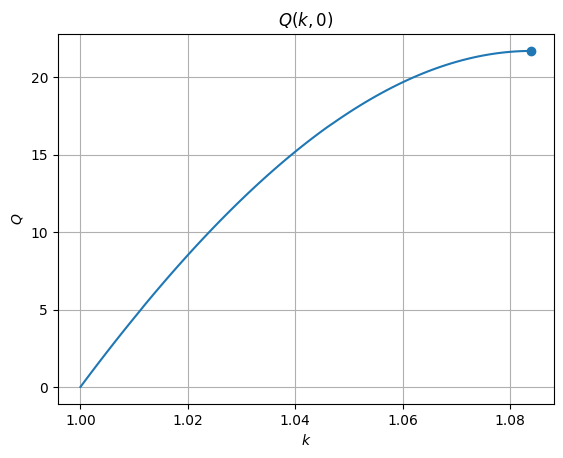

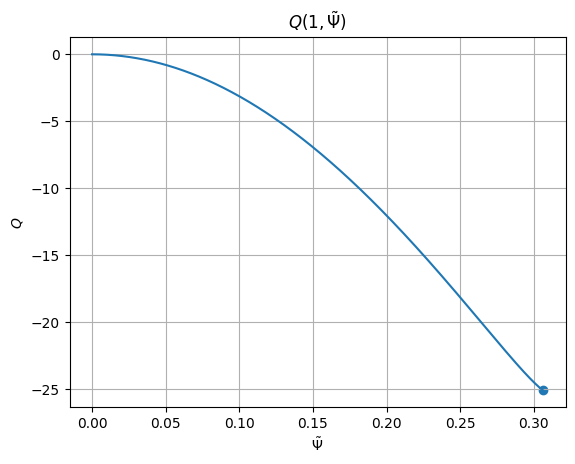

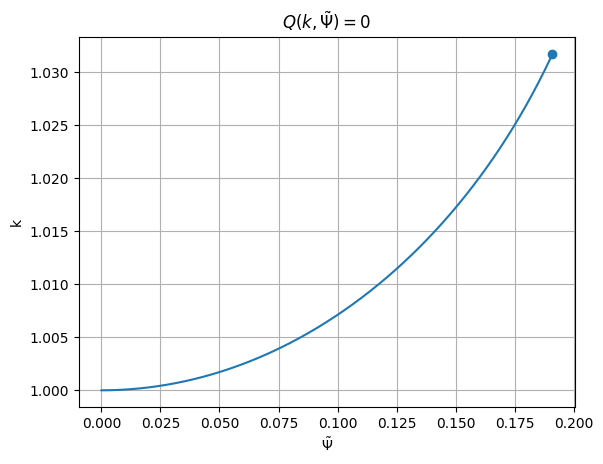

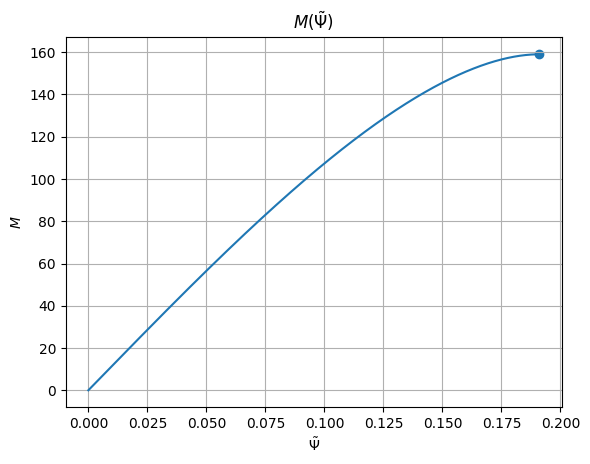

In [29]:
display_materials_plots(material_infos[:1], val_r_0, val_r_1)

In [30]:
def get_material_M_data(val_r_0, val_r_1, val_Psitilde_min, val_Psitilde_max, val_mu, val_lambda, val_l, val_m, val_n, list_len = 100):
    val_rho_0 = get_rho(val_r_0)
    val_rho_1 = get_rho(val_r_1)
    lmbd_sec_p = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], sec_p_subs.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    lmbd_cond = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], cond_subs.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    lmbd_Q_inner = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], Q_inner.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    lmbd_M_inner = sym.lambdify([k, Psitilde, rho, Ptilde, sym.diff(Ptilde, rho)], M_inner.subs(mu, val_mu).subs(lambdas, val_lambda).subs(ls, val_l).subs(ms, val_m).subs(ns, val_n).subs(r_1, val_r_1), "numpy")
    val_Psitilde_range = np.array([])
    root_k_range = np.array([])
    res_M_range = np.array([])
    root_k = 1.0 #Начальное приближение параметра k.
    for val_Psitilde in np.linspace(val_Psitilde_min, val_Psitilde_max, list_len):
        root_k = Solve_Q_Psi(val_rho_0, val_rho_1, val_Psitilde, lmbd_sec_p, lmbd_cond, lmbd_Q_inner, root_k) #Для каждого следующего вызова функции подставляем предыдущее найденное значение k.
        res_M = surface_simpson(val_rho_0, val_rho_1, root_k, val_Psitilde, lmbd_sec_p, lmbd_cond, lmbd_M_inner, list_len)
        val_Psitilde_range = np.append(val_Psitilde_range, val_Psitilde)
        root_k_range = np.append(root_k_range, root_k)
        res_M_range = np.append(res_M_range, res_M)
    return val_Psitilde_range, root_k_range, res_M_range

In [31]:
def get_materials_M_data(material_infos, val_r_0, val_r_1, val_Psitilde_min, val_Psitilde_max, list_len = 100, display_data = False):
    for material_info in material_infos:
        val_mu = material_info["$\mu$"]
        val_lambda = material_info["$\lambda$"]
        val_nu_1 = material_info["$\nu_1$"]
        val_nu_2 = material_info["$\nu_2$"]
        val_nu_3 = material_info["$\nu_3$"]
        val_l = 0.5*val_nu_1+val_nu_2
        val_m = val_nu_2+2*val_nu_3
        val_n = 4*val_nu_3
        val_Psitilde_range, root_k_range, res_M_range = get_material_M_data(val_r_0, val_r_1, val_Psitilde_min, val_Psitilde_max, val_mu, val_lambda, val_l, val_m, val_n, list_len)
        if display_data:
            if "Название" in material_info:
                print("Название материала: "+material_info["Название"]+".")
            display(sym.Eq(mu, val_mu, evaluate = False))
            display(sym.Eq(lambdas, val_lambda, evaluate = False))
            display(sym.Eq(sym.Symbol("l"), val_l, evaluate = False))
            display(sym.Eq(sym.Symbol("m"), val_m, evaluate = False))
            display(sym.Eq(sym.Symbol("n"), val_n, evaluate = False))
            plt.figure()
            plt.plot(val_Psitilde_range, root_k_range)
            plt.xlabel("$"+sym.printing.latex(Psitilde)+"$")
            plt.ylabel("$"+sym.printing.latex(k)+"$")
            plt.title("$Q("+sym.printing.latex(k)+","+sym.printing.latex(Psitilde)+")=0$")
            plt.grid(True)
            plt.show()
            plt.figure()
            plt.plot(val_Psitilde_range, res_M_range)
            plt.xlabel("$"+sym.printing.latex(Psitilde)+"$")
            plt.ylabel("$M$")
            plt.title("$M("+sym.printing.latex(Psitilde)+")$")
            plt.grid(True)
            plt.show()
        material_info.update({"$k$": root_k_range})
        material_info.update({"$M$": res_M_range})

In [32]:
val_Psitilde_min = 0.0
val_Psitilde_max = 0.05*float(sym.pi)
display(sym.Le(val_Psitilde_min, sym.Le(Psitilde, val_Psitilde_max, evaluate = False), evaluate = False))
list_len = 20

0.0 <= (Psitilde <= 0.15707963267949)

In [33]:
test_data_file_name = "Datasets/material_results_M_test_0.05Pi"
if os.path.isfile(test_data_file_name+".pickle"):
    df_test = pd.read_pickle(test_data_file_name+".pickle")
elif os.path.isfile(test_data_file_name+".feather"):
    df_test = pd.read_feather(test_data_file_name+".feather")
elif os.path.isfile(test_data_file_name+".csv"):
    df_test = pd.read_csv(test_data_file_name+".csv", encoding = "utf-8-sig")
    if "Unnamed: 0" in df_test.columns:
        df_test = df_test.drop(columns = "Unnamed: 0")
    df_test[df_test.columns[5]] = df_test[df_test.columns[5]].apply(lambda s: np.fromstring(s[1:-1], dtype = np.float64, sep = " "))
    df_test[df_test.columns[6]] = df_test[df_test.columns[6]].apply(lambda s: np.fromstring(s[1:-1], dtype = np.float64, sep = " "))
else:
    from tqdm import tqdm
    test_data = []
    for material_info in material_infos:
        material_data = {}
        material_data.update({"$\mu$": material_info["$\mu$"]})
        material_data.update({"$\lambda$": material_info["$\lambda$"]})
        material_data.update({"$\nu_1$": material_info["$\nu_1$"]})
        material_data.update({"$\nu_2$": material_info["$\nu_2$"]})
        material_data.update({"$\nu_3$": material_info["$\nu_3$"]})
        test_data.append(material_data)
    get_materials_M_data(tqdm(test_data), val_r_0, val_r_1, val_Psitilde_min, val_Psitilde_max, list_len, False)
    df_test = pd.DataFrame.from_dict(test_data)
display(df_test)
if not os.path.isfile(test_data_file_name+".pickle"):
    df_test.to_pickle(test_data_file_name+".pickle")
if not os.path.isfile(test_data_file_name+".feather"):
    df_test.to_feather(test_data_file_name+".feather")
if not os.path.isfile(test_data_file_name+".csv"):
    df_test.to_csv(test_data_file_name+".csv", encoding = "utf-8-sig")

,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$,$k$,$M$
0,0.78000,0.90900,3.580,-2.650,-1.820,"[1.0, 1.0000465707803576, 1.0001864209507842, ...","[0.0, 9.492151199410573, 18.959675285731205, 2..."
1,0.81800,1.09000,-1.750,-2.400,-1.690,"[1.0, 1.0000329574705091, 1.0001320427859057, ...","[0.0, 9.955446066092604, 19.890213939644912, 2..."
2,0.82100,1.11000,-3.580,-2.820,-1.770,"[1.0000000000000007, 1.0000387834110345, 1.000...","[0.0, 9.991409453127538, 19.958767881098407, 2..."
3,0.82000,1.10000,-1.340,-2.610,-1.670,"[1.0000000000000004, 1.0000346144909171, 1.000...","[0.0, 9.979620350385224, 19.937511537266836, 2..."
4,0.81900,1.09000,-3.230,-2.650,-1.770,"[0.9999999999999984, 1.000037498155892, 1.0001...","[0.0, 9.96722163572521, 19.911365229868075, 29..."
5,0.71600,0.87000,0.340,-5.520,-1.000,"[1.0, 1.000073251822272, 1.0002939934037645, 1...","[0.0, 8.710288433946381, 17.379706947443864, 2..."
6,0.80400,1.10000,-1.900,-2.300,-2.010,"[0.9999999999999988, 1.0000389954627618, 1.000...","[0.0, 9.784495213902536, 19.545271661747005, 2..."
7,0.80300,1.12900,-2.800,-2.700,-1.870,"[1.0, 1.000039875603291, 1.0001597369185058, 1...","[0.0, 9.772199326175482, 19.519958774911977, 2..."
8,0.26000,0.58000,-2.490,-0.990,-0.600,"[1.0, 1.0000300322099496, 1.0001203483993826, ...","[0.0, 3.164178317714649, 6.320916031284339, 9...."
9,0.26000,0.49100,-3.790,-1.980,-0.800,"[0.9999999999999991, 1.0000732378652395, 1.000...","[0.0, 3.1623908592296455, 6.306577550839029, 9..."


In [34]:
df_test_k = pd.DataFrame(df_test["$k$"].to_list(), columns = ["$k_{"+str(i)+"}$" for i in range(list_len)])
df_test_k = df_test_k.drop(df_test_k.columns[0], axis = 1)
df_test_M = pd.DataFrame(df_test["$M$"].to_list(), columns = ["$M_{"+str(i)+"}$" for i in range(list_len)])
df_test_M = df_test_M.drop(df_test_M.columns[0], axis = 1)
df_test = pd.concat([df_test.drop(columns = ["$k$", "$M$"]), df_test_k, df_test_M], axis = 1)
list_len -= 1
display(df_test)

,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$,$k_{1}$,$k_{2}$,$k_{3}$,$k_{4}$,$k_{5}$,...,$M_{10}$,$M_{11}$,$M_{12}$,$M_{13}$,$M_{14}$,$M_{15}$,$M_{16}$,$M_{17}$,$M_{18}$,$M_{19}$
0,0.78000,0.90900,3.580,-2.650,-1.820,1.000047,1.000186,1.000420,1.000748,1.001172,...,90.769905,98.850332,106.632434,114.081220,121.160588,127.829648,134.043500,139.751464,144.895071,149.404932
1,0.81800,1.09000,-1.750,-2.400,-1.690,1.000033,1.000132,1.000298,1.000531,1.000833,...,96.101936,104.893688,113.445380,121.732244,129.727715,137.404392,144.733016,151.682188,158.217369,164.301639
2,0.82100,1.11000,-3.580,-2.820,-1.770,1.000039,1.000155,1.000351,1.000626,1.000979,...,95.875868,104.501768,112.839721,120.859732,128.527034,135.805721,142.654929,149.030449,154.879841,160.146890
3,0.82000,1.10000,-1.340,-2.610,-1.670,1.000035,1.000139,1.000313,1.000558,1.000875,...,96.165802,104.920929,113.423168,121.645521,129.560138,137.137415,144.345735,151.150555,157.514993,163.397266
4,0.81900,1.09000,-3.230,-2.650,-1.770,1.000037,1.000150,1.000339,1.000605,1.000946,...,95.804295,104.463525,112.849740,120.933462,128.683038,136.063636,143.039340,149.568756,155.606956,161.100066
5,0.71600,0.87000,0.340,-5.520,-1.000,1.000073,1.000294,1.000658,1.001170,1.001831,...,79.355797,85.180428,90.244604,94.369032,97.306739,98.675294,97.790774,93.085077,76.678420,73.826581
6,0.80400,1.10000,-1.900,-2.300,-2.010,1.000039,1.000156,1.000353,1.000629,1.000987,...,93.863362,102.298781,110.451658,118.291407,125.783184,132.891134,139.575376,145.791544,151.487910,156.607321
7,0.80300,1.12900,-2.800,-2.700,-1.870,1.000040,1.000160,1.000360,1.000643,1.001007,...,93.615691,101.995999,110.083816,117.846589,125.249064,132.252102,138.814343,144.887696,150.417501,155.340845
8,0.26000,0.58000,-2.490,-0.990,-0.600,1.000030,1.000120,1.000272,1.000485,1.000761,...,30.392541,33.133612,35.786312,38.340978,40.787405,43.114723,45.311178,47.364005,49.259094,50.980637
9,0.26000,0.49100,-3.790,-1.980,-0.800,1.000073,1.000294,1.000667,1.001186,1.001869,...,28.317371,30.262320,31.880243,33.078765,33.709435,33.478455,31.449531,26.707736,27.484370,25.359055


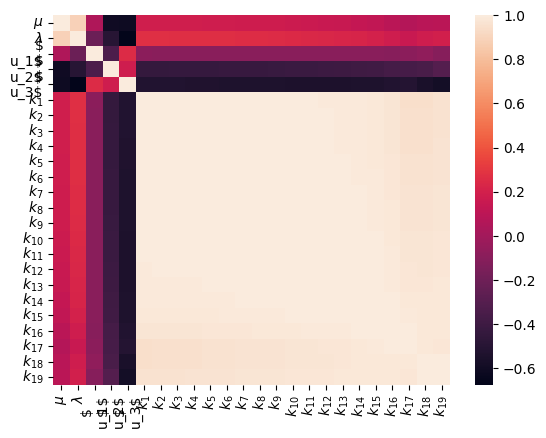

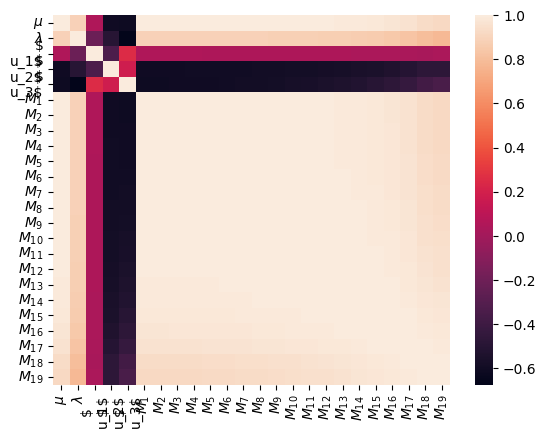

In [35]:
import seaborn as sns
df_test_corr_k = df_test.iloc[:, :5+list_len].corr()
df_test_corr_M = df_test.iloc[:, [0, 1, 2, 3, 4]+[list_len+i+5 for i in range(list_len)]].corr()
plt.figure()
sns.heatmap(df_test_corr_k)
plt.savefig("material_results_k_heatmap.svg")
plt.figure()
sns.heatmap(df_test_corr_M)
plt.savefig("material_results_M_heatmap.svg")

In [36]:
X_test = np.array(df_test.iloc[:, 5:].values.tolist())
y_test = np.array(df_test.iloc[:, :5].values.tolist())

In [37]:
if importlib.util.find_spec("sklearnex") is not None: #Intel(R) Extension for Scikit-learn
    from sklearnex import patch_sklearn
    patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [38]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_test = X_scaler.fit_transform(X_test)

In [39]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

In [40]:
def CreateExtraTreesRegressor():
    return ExtraTreesRegressor(n_estimators = 1000, criterion = "absolute_error", random_state = seed)

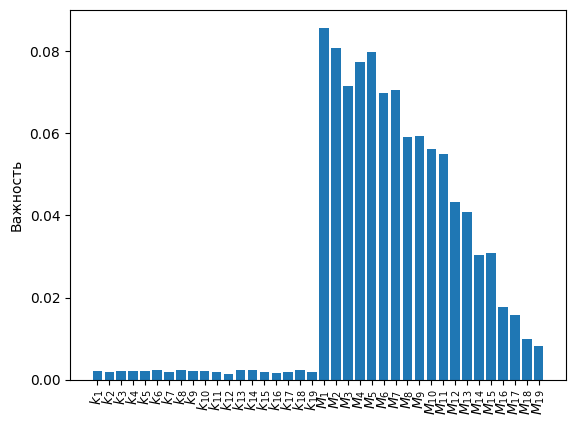

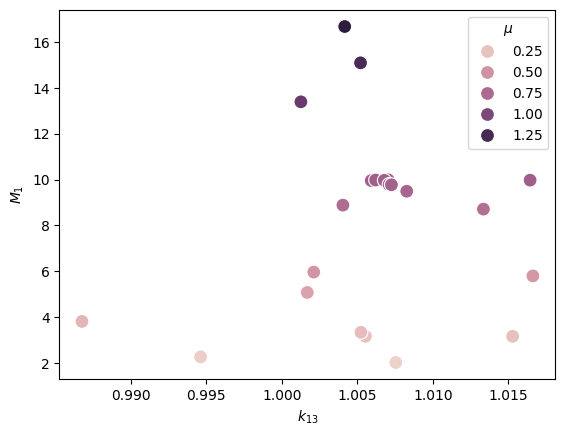

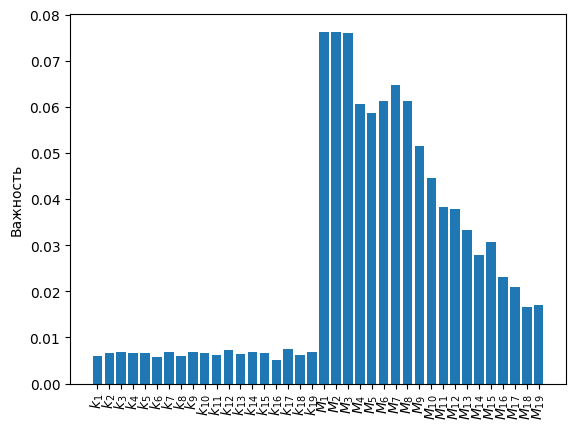

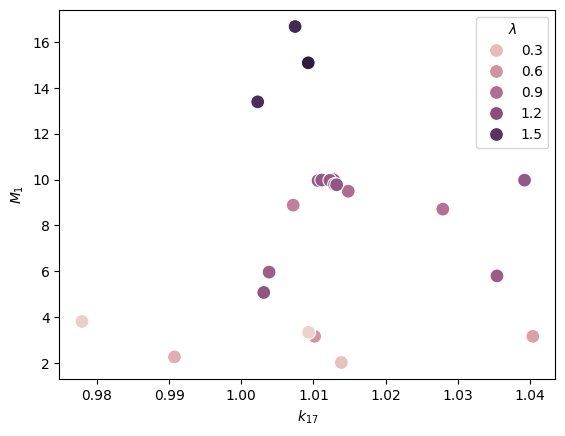

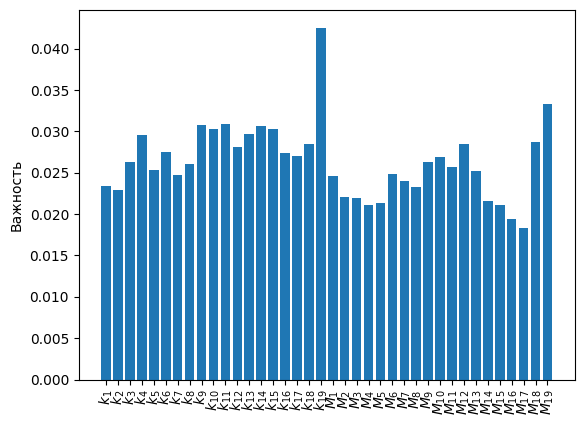

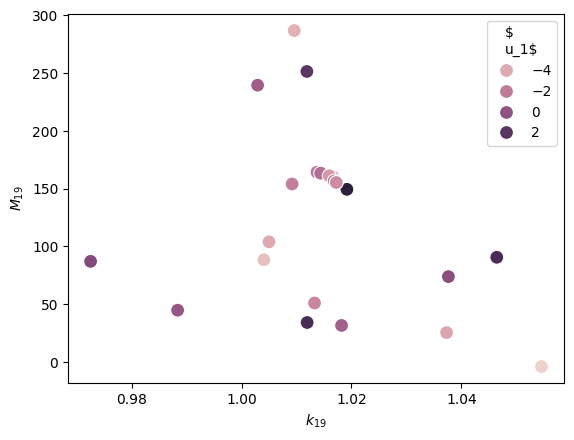

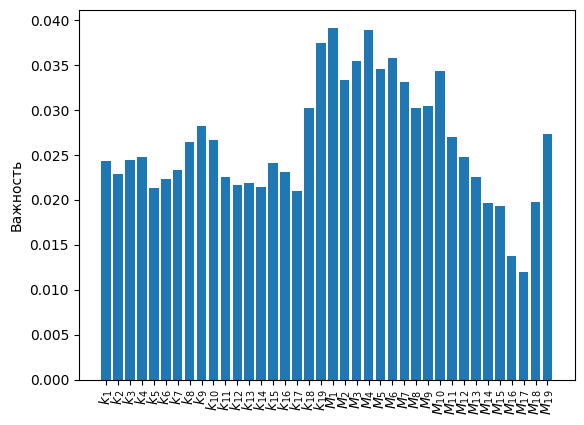

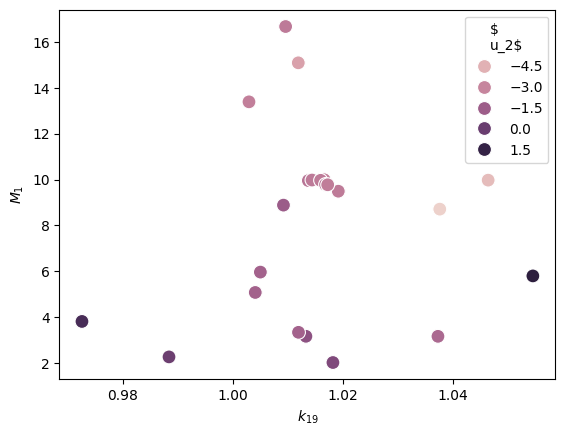

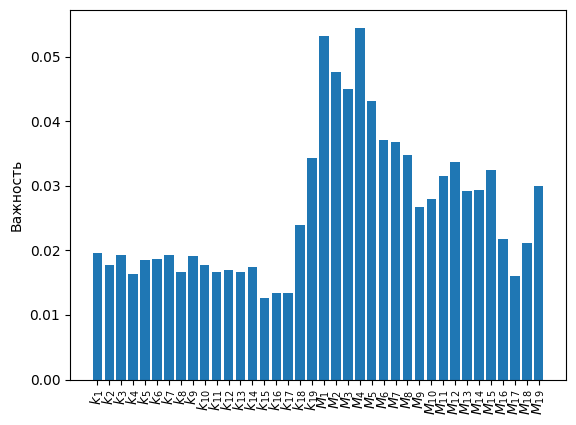

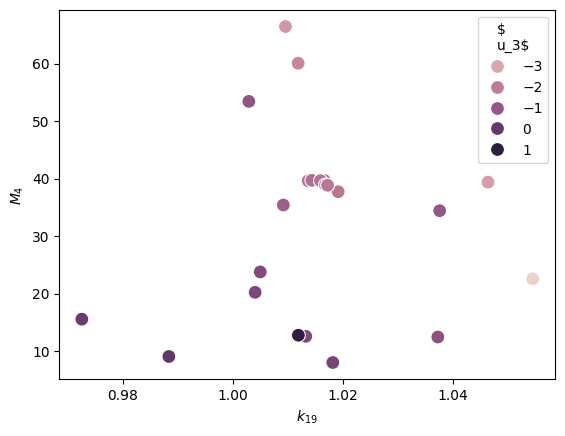

In [41]:
for i in range(y_test.shape[1]):
    estimator = CreateExtraTreesRegressor()
    estimator.fit(X_test, y_test[:, i])
    plt.figure()
    plt.bar([df_test.columns[j+5] for j in range(list_len*2)], estimator.feature_importances_)
    plt.ylabel("Важность")
    plt.xticks(rotation = 90)
    plt.savefig("material_results_M_feature_importance_"+str(i)+"_sklearn_ETR.svg")
    ind_k = np.argpartition(estimator.feature_importances_[:list_len], -1)[-1:][0]
    ind_M = np.argpartition(estimator.feature_importances_[list_len:], -1)[-1:][0]
    plt.figure()
    ax = sns.scatterplot(data = df_test, x = df_test.columns[ind_k+5], y = df_test.columns[ind_M+5+list_len], hue = df_test.columns[i], s = 100)
    plt.savefig("material_results_M_feature_importance_"+str(i)+"_most_important_features_sklearn_ETR.svg")

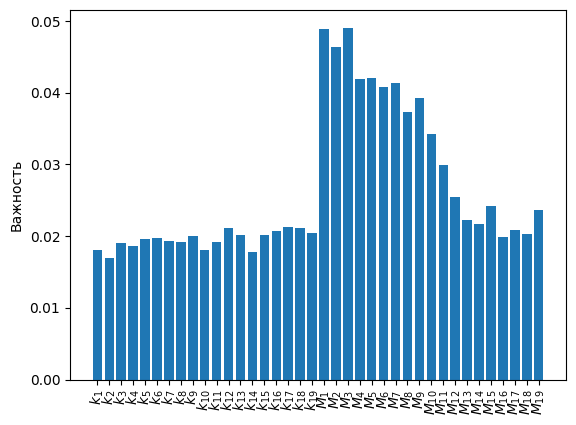

In [42]:
estimator = CreateExtraTreesRegressor()
estimator.fit(X_test, y_test)
fig = plt.figure()
plt.bar([df_test.columns[j+5] for j in range(list_len*2)], estimator.feature_importances_)
plt.ylabel("Важность")
plt.xticks(rotation = 90)
plt.savefig("material_results_M_feature_importance_sklearn_ETR.svg")
plt.show()

In [43]:
y_pred = cross_val_predict(CreateExtraTreesRegressor(), X_test, y_test, cv = LeaveOneOut(), n_jobs = -1)
prediction_data = []
for i in range(df_test.shape[0]):
    material_data = {}
    material_data.update({"$\mu$": y_test[i][0]})
    material_data.update({"$\mu^*$": y_pred[i][0]})
    material_data.update({"$\mu_{APE}$": np.abs((y_pred[i][0]-y_test[i][0])/y_test[i][0])*100.0})
    material_data.update({"$\lambda$": y_test[i][1]})
    material_data.update({"$\lambda^*$": y_pred[i][1]})
    material_data.update({"$\lambda_{APE}$": np.abs((y_pred[i][1]-y_test[i][1])/y_test[i][1])*100.0})
    material_data.update({"$\nu_1$": y_test[i][2]})
    material_data.update({"$\nu_1^*$": y_pred[i][2]})
    material_data.update({"${\nu_1}_{APE}$": np.abs((y_pred[i][2]-y_test[i][2])/y_test[i][2])*100.0})
    material_data.update({"$\nu_2$": y_test[i][3]})
    material_data.update({"$\nu_2^*$": y_pred[i][3]})
    material_data.update({"${\nu_2}_{APE}$": np.abs((y_pred[i][3]-y_test[i][3])/y_test[i][3])*100.0})
    material_data.update({"$\nu_3$": y_test[i][4]})
    material_data.update({"$\nu_3^*$": y_pred[i][4]})
    material_data.update({"${\nu_3}_{APE}$": np.abs((y_pred[i][4]-y_test[i][4])/y_test[i][4])*100.0})
    prediction_data.append(material_data)
score = r2_score(y_test, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Коэффициент детерминации:")
display(pd.DataFrame(score_data, index = [0]))
score = mean_absolute_error(y_test, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Средняя абсолютная ошибка:")
display(pd.DataFrame(score_data, index = [0]))
score = root_mean_squared_error(y_test, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Корень среднеквадратической ошибки:")
display(pd.DataFrame(score_data, index = [0]))
display(pd.DataFrame.from_dict(prediction_data))

Коэффициент детерминации:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.960283,0.607873,-0.431295,0.122147,0.112094


Средняя абсолютная ошибка:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.043675,0.184802,2.339248,1.024837,0.671622


Корень среднеквадратической ошибки:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.065879,0.274428,3.025799,1.515501,1.017966


,$\mu$,$\mu^*$,$\mu_{APE}$,$\lambda$,$\lambda^*$,$\lambda_{APE}$,$\nu_1$,$\nu_1^*$,${\nu_1}_{APE}$,$\nu_2$,$\nu_2^*$,${\nu_2}_{APE}$,$\nu_3$,$\nu_3^*$,${\nu_3}_{APE}$
0,0.78000,0.795844,2.031282,0.90900,1.102720,21.311331,3.580,-2.171280,160.650279,-2.650,-3.078580,16.172830,-1.820,-1.850100,1.653846
1,0.81800,0.815915,0.254890,1.09000,1.080320,0.888073,-1.750,-1.404630,19.735429,-2.400,-2.538830,5.784583,-1.690,-1.642560,2.807101
2,0.82100,0.814498,0.791961,1.11000,1.095790,1.280180,-3.580,-2.681770,25.090223,-2.820,-2.520060,10.636170,-1.770,-1.858540,5.002260
3,0.82000,0.818647,0.165000,1.10000,1.092140,0.714545,-1.340,-2.428290,81.215672,-2.610,-2.526440,3.201533,-1.670,-1.724640,3.271856
4,0.81900,0.819087,0.010623,1.09000,1.104920,1.368807,-3.230,-2.734450,15.342105,-2.650,-2.687900,1.430189,-1.770,-1.758240,0.664407
5,0.71600,0.673583,5.924162,0.87000,0.960728,10.428460,0.340,0.545730,60.508824,-5.520,-2.995420,45.735145,-1.000,-2.045700,104.570000
6,0.80400,0.808556,0.566667,1.10000,1.121278,1.934364,-1.900,-3.018640,58.875789,-2.300,-2.723880,18.429565,-2.010,-1.838200,8.547264
7,0.80300,0.799750,0.404732,1.12900,1.070559,5.176351,-2.800,-1.263770,54.865357,-2.700,-2.360120,12.588148,-1.870,-1.984280,6.111230
8,0.26000,0.275813,6.081746,0.58000,0.144526,75.081659,-2.490,2.261062,190.805703,-0.990,-1.335182,34.866869,-0.600,0.874231,245.705167
9,0.26000,0.244184,6.083077,0.49100,0.480600,2.118126,-3.790,-1.879218,50.416412,-1.980,-0.400174,79.789192,-0.800,-0.945485,18.185625


In [44]:
def CreateRidgeCV():
    return RidgeCV()

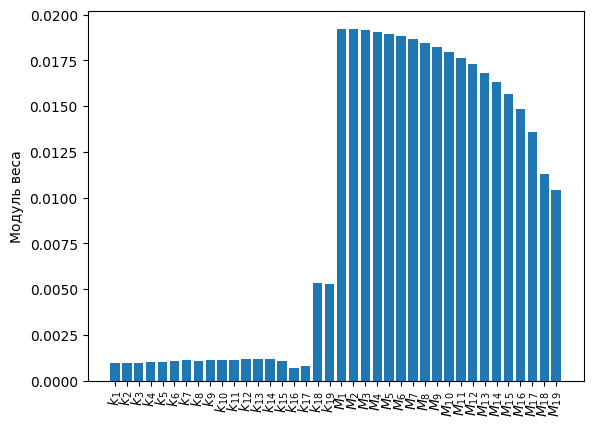

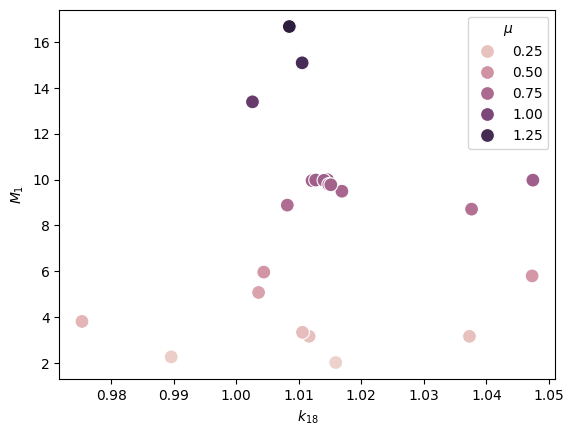

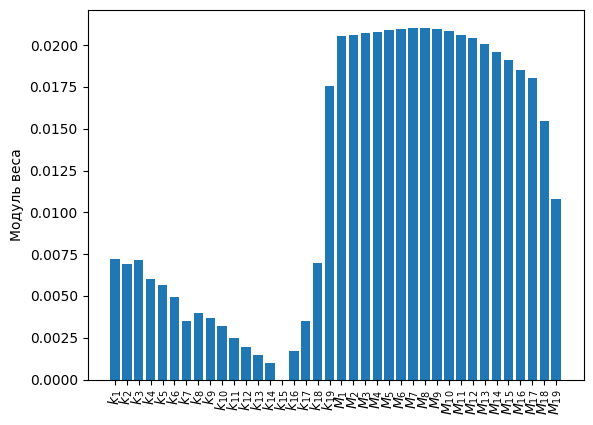

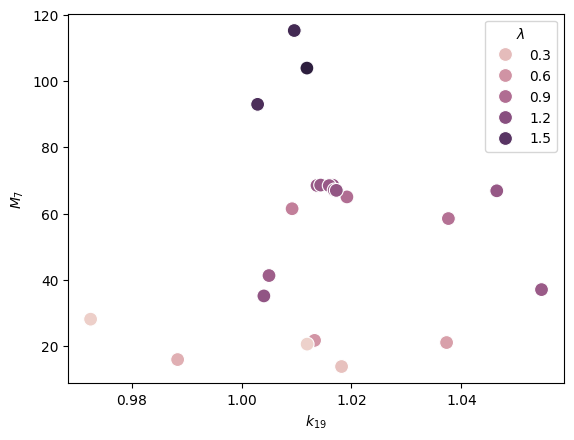

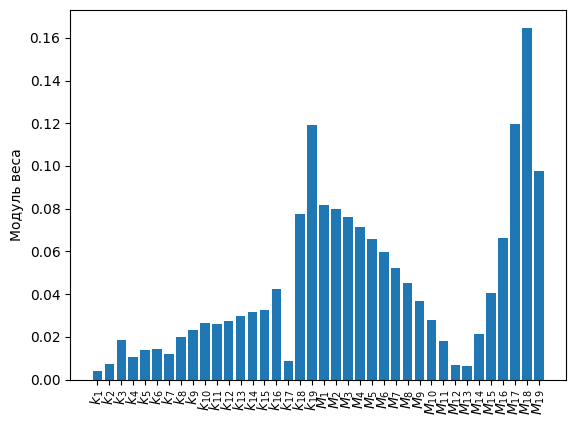

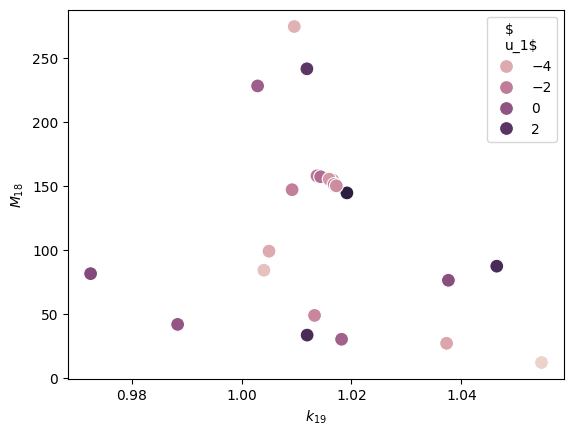

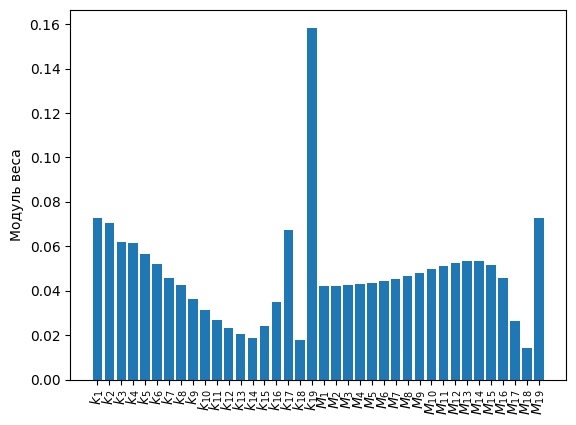

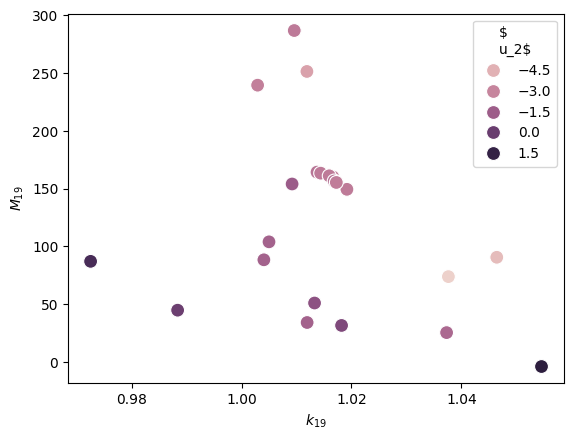

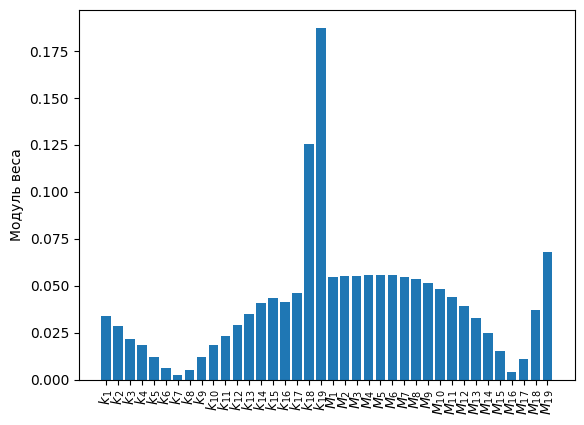

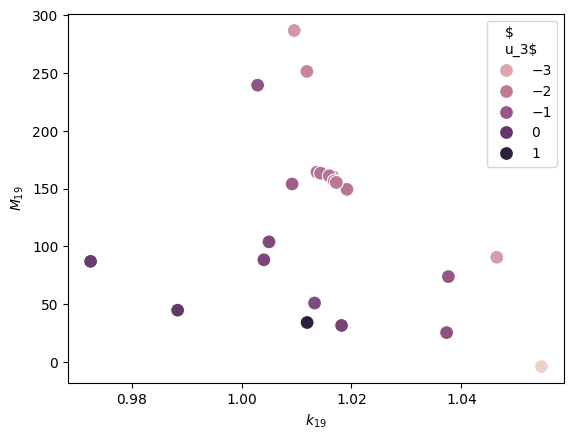

In [45]:
estimator = CreateRidgeCV()
estimator.fit(X_test, y_test)
for i in range(estimator.coef_.shape[0]):
    plt.figure()
    plt.bar([df_test.columns[j+5] for j in range(list_len*2)], np.abs(estimator.coef_[i]))
    plt.ylabel("Модуль веса")
    plt.xticks(rotation = 90)
    plt.savefig("material_results_M_feature_importance_"+str(i)+"_sklearn_RCV.svg")
    ind_k = np.argpartition(np.abs(estimator.coef_[i])[:list_len], -1)[-1:][0]
    ind_M = np.argpartition(np.abs(estimator.coef_[i])[list_len:], -1)[-1:][0]
    plt.figure()
    ax = sns.scatterplot(data = df_test, x = df_test.columns[ind_k+5], y = df_test.columns[ind_M+5+list_len], hue = df_test.columns[i], s = 100)
    plt.savefig("material_results_M_feature_importance_"+str(i)+"_most_important_features_sklearn_RCV.svg")

In [46]:
y_pred = estimator.predict(X_test)
prediction_data = []
for i in range(df_test.shape[0]):
    material_data = {}
    material_data.update({"$\mu$": y_test[i][0]})
    material_data.update({"$\mu^*$": y_pred[i][0]})
    material_data.update({"$\mu_{APE}$": np.abs((y_pred[i][0]-y_test[i][0])/y_test[i][0])*100.0})
    material_data.update({"$\lambda$": y_test[i][1]})
    material_data.update({"$\lambda^*$": y_pred[i][1]})
    material_data.update({"$\lambda_{APE}$": np.abs((y_pred[i][1]-y_test[i][1])/y_test[i][1])*100.0})
    material_data.update({"$\nu_1$": y_test[i][2]})
    material_data.update({"$\nu_1^*$": y_pred[i][2]})
    material_data.update({"${\nu_1}_{APE}$": np.abs((y_pred[i][2]-y_test[i][2])/y_test[i][2])*100.0})
    material_data.update({"$\nu_2$": y_test[i][3]})
    material_data.update({"$\nu_2^*$": y_pred[i][3]})
    material_data.update({"${\nu_2}_{APE}$": np.abs((y_pred[i][3]-y_test[i][3])/y_test[i][3])*100.0})
    material_data.update({"$\nu_3$": y_test[i][4]})
    material_data.update({"$\nu_3^*$": y_pred[i][4]})
    material_data.update({"${\nu_3}_{APE}$": np.abs((y_pred[i][4]-y_test[i][4])/y_test[i][4])*100.0})
    prediction_data.append(material_data)
score = r2_score(y_test, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Коэффициент детерминации:")
display(pd.DataFrame(score_data, index = [0]))
score = mean_absolute_error(y_test, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Средняя абсолютная ошибка:")
display(pd.DataFrame(score_data, index = [0]))
score = root_mean_squared_error(y_test, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Корень среднеквадратической ошибки:")
display(pd.DataFrame(score_data, index = [0]))
display(pd.DataFrame.from_dict(prediction_data))

Коэффициент детерминации:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.997014,0.79743,0.029633,0.49352,0.638738


Средняя абсолютная ошибка:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.013408,0.151253,2.046988,0.652195,0.405219


Корень среднеквадратической ошибки:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.018064,0.197243,2.4914,1.151135,0.649323


,$\mu$,$\mu^*$,$\mu_{APE}$,$\lambda$,$\lambda^*$,$\lambda_{APE}$,$\nu_1$,$\nu_1^*$,${\nu_1}_{APE}$,$\nu_2$,$\nu_2^*$,${\nu_2}_{APE}$,$\nu_3$,$\nu_3^*$,${\nu_3}_{APE}$
0,0.78000,0.784644,0.595404,0.90900,1.095621,20.530387,3.580,-1.534792,142.871286,-2.650,-2.635697,0.539739,-1.820,-1.658158,8.892402
1,0.81800,0.819949,0.238214,1.09000,1.120118,2.763135,-1.750,-1.418989,18.914941,-2.400,-2.537593,5.733052,-1.690,-1.571313,7.022926
2,0.82100,0.821591,0.071932,1.11000,1.129158,1.725922,-3.580,-1.457647,59.283603,-2.820,-2.623794,6.957668,-1.770,-1.657178,6.374103
3,0.82000,0.821360,0.165904,1.10000,1.123690,2.153651,-1.340,-1.428122,6.576306,-2.610,-2.564733,1.734358,-1.670,-1.593733,4.566861
4,0.81900,0.820301,0.158847,1.09000,1.126099,3.311874,-3.230,-1.451047,55.075939,-2.650,-2.602436,1.794859,-1.770,-1.635436,7.602512
5,0.71600,0.695084,2.921280,0.87000,1.024971,17.812714,0.340,-1.545383,554.524525,-5.520,-2.713765,50.837588,-1.000,-2.103041,110.304132
6,0.80400,0.805577,0.196192,1.10000,1.111056,1.005129,-1.900,-1.468572,22.706747,-2.300,-2.583863,12.341888,-2.010,-1.633822,18.715323
7,0.80300,0.803958,0.119278,1.12900,1.110192,1.665881,-2.800,-1.472566,47.408358,-2.700,-2.591082,4.033998,-1.870,-1.642551,12.163055
8,0.26000,0.286791,10.304143,0.58000,0.502768,13.315781,-2.490,-1.640229,34.127352,-0.990,-1.061412,7.213288,-0.600,-0.559563,6.739474
9,0.26000,0.299857,15.329595,0.49100,0.567355,15.550858,-3.790,-2.024402,46.585701,-1.980,-1.812095,8.480030,-0.800,-1.382783,72.847914


In [47]:
material_infos_new = []
material_infos_new.append({'Название': 'Рельсовая сталь #1', '$\lambda$': 1.158, '$\mu$': 0.799, '$l$': -2.48, '$m$': -6.23, '$n$': -7.14, "$\nu_1$": None, "$\nu_2$": None, "$\nu_3$": None})
material_infos_new.append({'Название': 'Рельсовая сталь #4', '$\lambda$': 1.107, '$\mu$': 0.824, '$l$': -3.02, '$m$': -6.16, '$n$': -7.24, "$\nu_1$": None, "$\nu_2$": None, "$\nu_3$": None})
for material_info in material_infos_new:
    material_info["$\nu_3$"] = 0.25*material_info["$n$"]
    material_info["$\nu_2$"] = material_info["$m$"]-2.0*material_info["$\nu_3$"]
    material_info["$\nu_1$"] = 2.0*(material_info["$l$"]-material_info["$\nu_2$"])
    material_info.pop("$l$")
    material_info.pop("$m$")
    material_info.pop("$n$")

In [48]:
val_Psitilde_min = 0.0
val_Psitilde_max = 0.05*float(sym.pi)
display(sym.Le(val_Psitilde_min, sym.Le(Psitilde, val_Psitilde_max, evaluate = False), evaluate = False))
list_len = 20

0.0 <= (Psitilde <= 0.15707963267949)

In [49]:
new_data_file_name = "Datasets/material_results_M_railsteel_0.05Pi"
if os.path.isfile(new_data_file_name+".pickle"):
    df_new = pd.read_pickle(new_data_file_name+".pickle")
elif os.path.isfile(new_data_file_name+".feather"):
    df_new = pd.read_feather(new_data_file_name+".feather")
elif os.path.isfile(new_data_file_name+".csv"):
    df_new = pd.read_csv(new_data_file_name+".csv", encoding = "utf-8-sig")
    if "Unnamed: 0" in df_new.columns:
        df_new = df_new.drop(columns = "Unnamed: 0")
    df_new[df_new.columns[5]] = df_new[df_new.columns[5]].apply(lambda s: np.fromstring(s[1:-1], dtype = np.float64, sep = " "))
    df_new[df_new.columns[6]] = df_new[df_new.columns[6]].apply(lambda s: np.fromstring(s[1:-1], dtype = np.float64, sep = " "))
else:
    from tqdm import tqdm
    new_data = []
    for material_info in material_infos_new:
        material_data = {}
        material_data.update({"$\mu$": material_info["$\mu$"]})
        material_data.update({"$\lambda$": material_info["$\lambda$"]})
        material_data.update({"$\nu_1$": material_info["$\nu_1$"]})
        material_data.update({"$\nu_2$": material_info["$\nu_2$"]})
        material_data.update({"$\nu_3$": material_info["$\nu_3$"]})
        new_data.append(material_data)
    get_materials_M_data(tqdm(new_data), val_r_0, val_r_1, val_Psitilde_min, val_Psitilde_max, list_len, False)
    df_new = pd.DataFrame.from_dict(new_data)
display(df_new)
if not os.path.isfile(new_data_file_name+".pickle"):
    df_new.to_pickle(new_data_file_name+".pickle")
if not os.path.isfile(new_data_file_name+".feather"):
    df_new.to_feather(new_data_file_name+".feather")
if not os.path.isfile(new_data_file_name+".csv"):
    df_new.to_csv(new_data_file_name+".csv", encoding = "utf-8-sig")

,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$,$k$,$M$
0,0.799,1.158,0.36,-2.66,-1.785,"[1.0, 1.0000370213927652, 1.0001482829553154, ...","[0.0, 9.723717098106626, 19.42429436954132, 29..."
1,0.824,1.107,-0.96,-2.54,-1.810,"[0.9999999999999994, 1.000036375234913, 1.0001...","[0.0, 10.028160248369824, 20.033635337507715, ..."


In [50]:
df_new_k = pd.DataFrame(df_new["$k$"].to_list(), columns = ["$k_{"+str(i)+"}$" for i in range(list_len)])
df_new_k = df_new_k.drop(df_new_k.columns[0], axis = 1)
df_new_M = pd.DataFrame(df_new["$M$"].to_list(), columns = ["$M_{"+str(i)+"}$" for i in range(list_len)])
df_new_M = df_new_M.drop(df_new_M.columns[0], axis = 1)
df_new = pd.concat([df_new.drop(columns = ["$k$", "$M$"]), df_new_k, df_new_M], axis = 1)
list_len -= 1
display(df_new)

,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$,$k_{1}$,$k_{2}$,$k_{3}$,$k_{4}$,$k_{5}$,...,$M_{10}$,$M_{11}$,$M_{12}$,$M_{13}$,$M_{14}$,$M_{15}$,$M_{16}$,$M_{17}$,$M_{18}$,$M_{19}$
0,0.799,1.158,0.36,-2.66,-1.785,1.000037,1.000148,1.000334,1.000596,1.000935,...,93.363530,101.778261,109.920949,117.762239,125.271337,132.414645,139.156506,145.457662,151.274470,156.557508
1,0.824,1.107,-0.96,-2.54,-1.810,1.000036,1.000146,1.000329,1.000586,1.000919,...,96.486303,105.232651,113.712024,121.899358,129.760938,137.266009,144.380118,151.065636,157.280427,162.978386


In [51]:
X_new = np.array(df_new.iloc[:, 5:].values.tolist())
y_new = np.array(df_new.iloc[:, :5].values.tolist())

In [52]:
X_new = X_scaler.transform(X_new)

In [53]:
y_pred = estimator.predict(X_new)
prediction_data = []
for i in range(df_new.shape[0]):
    material_data = {}
    material_data.update({"$\mu$": y_new[i][0]})
    material_data.update({"$\mu^*$": y_pred[i][0]})
    material_data.update({"$\mu_{APE}$": np.abs((y_pred[i][0]-y_new[i][0])/y_new[i][0])*100.0})
    material_data.update({"$\lambda$": y_new[i][1]})
    material_data.update({"$\lambda^*$": y_pred[i][1]})
    material_data.update({"$\lambda_{APE}$": np.abs((y_pred[i][1]-y_new[i][1])/y_new[i][1])*100.0})
    material_data.update({"$\nu_1$": y_new[i][2]})
    material_data.update({"$\nu_1^*$": y_pred[i][2]})
    material_data.update({"${\nu_1}_{APE}$": np.abs((y_pred[i][2]-y_new[i][2])/y_new[i][2])*100.0})
    material_data.update({"$\nu_2$": y_new[i][3]})
    material_data.update({"$\nu_2^*$": y_pred[i][3]})
    material_data.update({"${\nu_2}_{APE}$": np.abs((y_pred[i][3]-y_new[i][3])/y_new[i][3])*100.0})
    material_data.update({"$\nu_3$": y_new[i][4]})
    material_data.update({"$\nu_3^*$": y_pred[i][4]})
    material_data.update({"${\nu_3}_{APE}$": np.abs((y_pred[i][4]-y_new[i][4])/y_new[i][4])*100.0})
    prediction_data.append(material_data)
score = r2_score(y_new, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Коэффициент детерминации:")
display(pd.DataFrame(score_data, index = [0]))
score = mean_absolute_error(y_new, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Средняя абсолютная ошибка:")
display(pd.DataFrame(score_data, index = [0]))
score = root_mean_squared_error(y_new, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Корень среднеквадратической ошибки:")
display(pd.DataFrame(score_data, index = [0]))
display(pd.DataFrame.from_dict(prediction_data))

Коэффициент детерминации:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.993297,-1.826413,-3.026476,-1.473709,-231.243446


Средняя абсолютная ошибка:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.001023,0.039583,1.14503,0.089509,0.190406


Корень среднеквадратической ошибки:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.001023,0.04287,1.324361,0.094368,0.190494


,$\mu$,$\mu^*$,$\mu_{APE}$,$\lambda$,$\lambda^*$,$\lambda_{APE}$,$\nu_1$,$\nu_1^*$,${\nu_1}_{APE}$,$\nu_2$,$\nu_2^*$,${\nu_2}_{APE}$,$\nu_3$,$\nu_3^*$,${\nu_3}_{APE}$
0,0.799,0.799990,0.123899,1.158,1.101954,4.839929,0.36,-1.450492,502.914340,-2.66,-2.540599,4.488755,-1.785,-1.588804,10.991345
1,0.824,0.825056,0.128130,1.107,1.130120,2.088563,-0.96,-1.439569,49.955072,-2.54,-2.599617,2.347110,-1.810,-1.625383,10.199828


In [54]:
val_Psitilde_min = 0.0
val_Psitilde_max = 0.05*float(sym.pi)
display(sym.Le(val_Psitilde_min, sym.Le(Psitilde, val_Psitilde_max, evaluate = False), evaluate = False))
list_len = 20

0.0 <= (Psitilde <= 0.15707963267949)

In [55]:
train_data_file_name = "Datasets/material_results_M_train_0.05Pi_4440"
if os.path.isfile(train_data_file_name+".pickle"):
    df_train = pd.read_pickle(train_data_file_name+".pickle")
elif os.path.isfile(train_data_file_name+".feather"):
    df_train = pd.read_feather(train_data_file_name+".feather")
elif os.path.isfile(train_data_file_name+".csv"):
    df_train = pd.read_csv(train_data_file_name+".csv", encoding = "utf-8-sig")
    if "Unnamed: 0" in df_train.columns:
        df_train = df_train.drop(columns = "Unnamed: 0")
    df_train[df_train.columns[5]] = df_train[df_train.columns[5]].apply(lambda s: np.fromstring(s[1:-1], dtype = np.float64, sep = " "))
    df_train[df_train.columns[6]] = df_train[df_train.columns[6]].apply(lambda s: np.fromstring(s[1:-1], dtype = np.float64, sep = " "))
else:
    df_train = None
assert df_train is not None, "Тренировочные данные не найдены."
display(df_train)
if not os.path.isfile(train_data_file_name+".pickle"):
    df_train.to_pickle(train_data_file_name+".pickle")
if not os.path.isfile(train_data_file_name+".feather"):
    df_train.to_feather(train_data_file_name+".feather")
if not os.path.isfile(train_data_file_name+".csv"):
    df_train.to_csv(train_data_file_name+".csv", encoding = "utf-8-sig")

,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$,$k$,$M$
0,1.060199,1.175119,4.223309,1.954982,0.668442,"[0.9999999999999977, 0.9999373850980082, 0.999...","[0.0, 12.912829627261573, 25.85718583076396, 3..."
1,0.934900,0.678878,-4.560123,-5.433176,1.955589,"[1.0, 1.0000226657535052, 1.0000930136005242, ...","[0.0, 11.3698154965785, 22.66584437248048, 33...."
2,0.902725,1.077164,5.432703,1.786148,-2.231237,"[0.9999999999999919, 0.9999918201764861, 0.999...","[0.0, 10.989450438011472, 21.973232221739668, ..."
3,1.021150,1.727626,2.655574,1.744105,1.669546,"[1.0000000000000102, 0.9999295198556898, 0.999...","[0.0, 12.435725245544203, 24.89276438827456, 3..."
4,0.879959,0.614681,-0.879454,1.568620,-2.094217,"[1.000000000000009, 0.9999834716323842, 0.9999...","[0.0, 10.713161467317379, 21.42593504056849, 3..."
...,...,...,...,...,...,...,...
4435,0.547015,1.288573,0.044432,-7.253548,0.466119,"[1.0, 1.00002976, 1.00011987, 1.00026914, 1.00...","[0.0, 6.65117534, 13.25095051, 19.74692412, 26..."
4436,1.001564,0.860793,-5.493621,-1.769730,-0.165640,"[1.0, 0.99999633, 0.99998535, 0.99996717, 0.99...","[0.0, 12.19247028, 24.37737865, 36.54712384, 4..."
4437,0.698036,1.639603,4.362781,-5.482224,1.867839,"[1.0, 0.99997071, 0.99988306, 0.99973753, 0.99...","[0.0, 8.49448977, 16.9657369, 25.39041398, 33...."
4438,0.392364,1.847479,-4.406707,-2.216694,-3.537008,"[1.0, 1.00012433, 1.00050107, 1.00114196, 1.00...","[0.0, 4.76634281, 9.46889631, 14.04163225, 18...."


In [56]:
df_train_k = pd.DataFrame(df_train["$k$"].to_list(), columns = ["$k_{"+str(i)+"}$" for i in range(list_len)])
df_train_k = df_train_k.drop(df_train_k.columns[0], axis = 1)
df_train_M = pd.DataFrame(df_train["$M$"].to_list(), columns = ["$M_{"+str(i)+"}$" for i in range(list_len)])
df_train_M = df_train_M.drop(df_train_M.columns[0], axis = 1)
df_train = pd.concat([df_train.drop(columns = ["$k$", "$M$"]), df_train_k, df_train_M], axis = 1)
list_len -= 1
display(df_train)

,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$,$k_{1}$,$k_{2}$,$k_{3}$,$k_{4}$,$k_{5}$,...,$M_{10}$,$M_{11}$,$M_{12}$,$M_{13}$,$M_{14}$,$M_{15}$,$M_{16}$,$M_{17}$,$M_{18}$,$M_{19}$
0,1.060199,1.175119,4.223309,1.954982,0.668442,0.999937,0.999749,0.999434,0.998997,0.998432,...,134.037978,148.512525,163.272854,178.321020,193.655110,209.316135,225.272656,241.542420,258.106345,275.051207
1,0.934900,0.678878,-4.560123,-5.433176,1.955589,1.000023,1.000093,1.000217,1.000320,1.000455,...,103.915686,112.327432,120.272428,127.662153,134.486057,140.707282,146.285371,151.175265,155.233386,158.482898
2,0.902725,1.077164,5.432703,1.786148,-2.231237,0.999992,0.999967,0.999926,0.999869,0.999794,...,108.849433,119.470689,129.999248,140.428482,150.745805,160.919514,170.960227,180.856753,190.571989,200.081576
3,1.021150,1.727626,2.655574,1.744105,1.669546,0.999930,0.999718,0.999364,0.998868,0.998228,...,127.740421,141.266167,154.989763,168.921302,183.060270,197.421548,212.001673,226.804974,241.815642,257.026259
4,0.879959,0.614681,-0.879454,1.568620,-2.094217,0.999983,0.999934,0.999851,0.999735,0.999599,...,106.796984,117.325858,127.789216,138.174232,148.456043,158.610523,168.633669,178.486392,188.154242,197.608792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4435,0.547015,1.288573,0.044432,-7.253548,0.466119,1.000030,1.000120,1.000269,1.000482,1.000759,...,57.354409,60.706329,63.229154,64.723274,64.935203,63.432342,59.428503,50.591455,37.736858,37.921742
4436,1.001564,0.860793,-5.493621,-1.769730,-0.165640,0.999996,0.999985,0.999967,0.999942,0.999910,...,120.645942,132.403067,144.068337,155.631571,167.180761,178.552086,189.803678,200.927590,211.916165,222.762146
4437,0.698036,1.639603,4.362781,-5.482224,1.867839,0.999971,0.999883,0.999738,0.999535,0.999277,...,81.046636,88.178377,95.060257,101.634181,107.870398,113.738741,119.208817,124.250254,128.832978,132.920288
4438,0.392364,1.847479,-4.406707,-2.216694,-3.537008,1.000124,1.000501,1.001142,1.002068,1.003316,...,34.271639,32.063552,26.061270,27.390462,28.522763,29.504599,29.929533,30.382555,30.502594,29.212671


In [57]:
X_train = np.array(df_train.iloc[:, 5:].values.tolist())
y_train = np.array(df_train.iloc[:, :5].values.tolist())

In [58]:
X_train = X_scaler.transform(X_train)

In [59]:
estimator = Ridge()
estimator.fit(X_train, y_train)

Ridge()

In [60]:
y_pred = estimator.predict(X_new)
prediction_data = []
for i in range(df_new.shape[0]):
    material_data = {}
    material_data.update({"$\mu$": y_new[i][0]})
    material_data.update({"$\mu^*$": y_pred[i][0]})
    material_data.update({"$\mu_{APE}$": np.abs((y_pred[i][0]-y_new[i][0])/y_new[i][0])*100.0})
    material_data.update({"$\lambda$": y_new[i][1]})
    material_data.update({"$\lambda^*$": y_pred[i][1]})
    material_data.update({"$\lambda_{APE}$": np.abs((y_pred[i][1]-y_new[i][1])/y_new[i][1])*100.0})
    material_data.update({"$\nu_1$": y_new[i][2]})
    material_data.update({"$\nu_1^*$": y_pred[i][2]})
    material_data.update({"${\nu_1}_{APE}$": np.abs((y_pred[i][2]-y_new[i][2])/y_new[i][2])*100.0})
    material_data.update({"$\nu_2$": y_new[i][3]})
    material_data.update({"$\nu_2^*$": y_pred[i][3]})
    material_data.update({"${\nu_2}_{APE}$": np.abs((y_pred[i][3]-y_new[i][3])/y_new[i][3])*100.0})
    material_data.update({"$\nu_3$": y_new[i][4]})
    material_data.update({"$\nu_3^*$": y_pred[i][4]})
    material_data.update({"${\nu_3}_{APE}$": np.abs((y_pred[i][4]-y_new[i][4])/y_new[i][4])*100.0})
    prediction_data.append(material_data)
score = r2_score(y_new, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Коэффициент детерминации:")
display(pd.DataFrame(score_data, index = [0]))
score = mean_absolute_error(y_new, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Средняя абсолютная ошибка:")
display(pd.DataFrame(score_data, index = [0]))
score = root_mean_squared_error(y_new, y_pred, multioutput = "raw_values")
score_data = {}
score_data.update({"$\mu$": score[0]})
score_data.update({"$\lambda$": score[1]})
score_data.update({"$\nu_1$": score[2]})
score_data.update({"$\nu_2$": score[3]})
score_data.update({"$\nu_3$": score[4]})
print("Корень среднеквадратической ошибки:")
display(pd.DataFrame(score_data, index = [0]))
display(pd.DataFrame.from_dict(prediction_data))

Коэффициент детерминации:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.999577,-0.39749,-1.050354,-69.242199,-117.684902


Средняя абсолютная ошибка:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.000257,0.025614,0.672936,0.499232,0.135872


Корень среднеквадратической ошибки:


,$\mu$,$\lambda$,$\nu_1$,$\nu_2$,$\nu_3$
0,0.000257,0.030145,0.945058,0.502864,0.136178


,$\mu$,$\mu^*$,$\mu_{APE}$,$\lambda$,$\lambda^*$,$\lambda_{APE}$,$\nu_1$,$\nu_1^*$,${\nu_1}_{APE}$,$\nu_2$,$\nu_2^*$,${\nu_2}_{APE}$,$\nu_3$,$\nu_3^*$,${\nu_3}_{APE}$
0,0.799,0.799271,0.033893,1.158,1.116491,3.584540,0.36,-0.976481,371.244591,-2.66,-2.100445,21.035917,-1.785,-1.658253,7.100677
1,0.824,0.824243,0.029447,1.107,1.116718,0.877872,-0.96,-0.969392,0.978377,-2.54,-2.101090,17.279903,-1.810,-1.665003,8.010899
